In [2]:
import numpy as np
import networkx as nx
import numpy.linalg as nplin
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp, quad
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
from math import factorial as facto
from math import comb
import time

In [38]:
from numpy.linalg import pinv, det
# Note: I was not able to jit from numba for snmf and onmf to get reduction mat

import logging
import logging.config
import scipy.sparse


_EPS = np.finfo(float).eps


class PyMFBase:
    """
    PyMF Base Class. Does nothing useful apart from providing
    some basic methods.
    """

    _EPS = _EPS  # some small value

    def __init__(self, data, W_init=None, H_init=None, num_bases=4):
        """
        """

        def setup_logging():
            # create logger
            self._logger = logging.getLogger("pymf")

            # add ch to logger
            if len(self._logger.handlers) < 1:
                # create console handler and set level to debug
                ch = logging.StreamHandler()
                ch.setLevel(logging.DEBUG)
                # create formatter
                formatter = logging.Formatter(
                    "%(asctime)s [%(levelname)s] %(message)s")

                # add formatter to ch
                ch.setFormatter(formatter)

                self._logger.addHandler(ch)

        setup_logging()

        # set variables
        self.data = data
        self._num_bases = num_bases

        self.W_init = W_init
        self.H_init = H_init

        self._data_dimension, self._num_samples = self.data.shape

    def residual(self):
        """ Returns the residual in % of the total amount of data
        Returns
        -------
        residual : float
        """
        res = np.sum(np.abs(self.data - np.dot(self.W, self.H)))
        total = 100.0 * res / np.sum(np.abs(self.data))
        return total

    def frobenius_norm(self):
        """ Frobenius norm (||data - WH||) of a data matrix and a low rank
        approximation given by WH. Minimizing the Fnorm is the most common
        optimization criterion for matrix factorization methods.
        Returns:
        -------
        frobenius norm: F = ||data - WH||
        """
        # check if W and H exist
        if hasattr(self, 'H') and hasattr(self, 'W'):
            if scipy.sparse.issparse(self.data):
                tmp = self.data[:, :] - (self.W * self.H)
                tmp = tmp.multiply(tmp).sum()
                err = np.sqrt(tmp)
            else:
                err = np.sqrt(
                    np.sum((self.data[:, :] - np.dot(self.W, self.H)) ** 2))
        else:
            err = None

        return err

    def _init_w(self):
        """ Initalize W to random values in [0,1] if W_init is None.
            Else it initializes to the given W_init matrix.
        """
        if self.W_init is None:
            # add a small value, otherwise nmf and related methods get
            # into trouble as
            # they have difficulties recovering from zero.
            self.W = np.random.random(
                (self._data_dimension, self._num_bases)) + 10 ** -4
        else:
            self.W = self.W_init

    def _init_h(self):
        """ Initalize H to random values in [0,1] if H_init is None.
            Else it initializes to the given H_init matrix.
        """
        if self.H_init is None:
            # add a small value, otherwise nmf and related methods get
            # into trouble as
            # they have difficulties recovering from zero.
            self.H = np.random.random(
                (self._num_bases, self._num_samples)) + 10**(-4)
        else:
            self.H = self.H_init

    def _update_h(self):
        """ Overwrite for updating H.
        """
        pass

    def _update_w(self):
        """ Overwrite for updating W.
        """
        pass

    def _converged(self, i):
        """
        If the optimization of the approximation is below the machine precision
        return True.
        Parameters
        ----------
            i   : index of the update step
        Returns
        -------
            converged : boolean
        """
        derr = np.abs(self.ferr[i] - self.ferr[i - 1]) / self._num_samples
        if derr < self._EPS:
            return True
        else:
            return False

    def factorize(self, niter=100,  # show_progress=False,
                  compute_w=True, compute_h=True, compute_err=True):
        """ Factorize s.t. WH = data

        Parameters
        ----------
        niter : int
                number of iterations.
        # show_progress : bool
        #         print some extra information to stdout.
        compute_h : bool
                iteratively update values for H.
        compute_w : bool
                iteratively update values for W.
        compute_err : bool
                compute Frobenius norm |data-WH| after each update and store
                it to .ferr[k].

        Updated Values
        --------------
        .W : updated values for W.
        .H : updated values for H.
        .ferr : Frobenius norm |data-WH| for each iteration.
        """

        # if show_progress:
        #     self._logger.setLevel(logging.INFO)
        # else:
        #     self._logger.setLevel(logging.ERROR)

        # create W and H if they don't already exist
        # -> any custom initialization to W, H should be done before
        if not hasattr(self, 'W') and compute_w:
            self._init_w()

        if not hasattr(self, 'H') and compute_h:
            self._init_h()

        # Computation of the error can take quite long for large matrices,
        # thus we make it optional.
        if compute_err:
            self.ferr = np.zeros(niter)

        for i in range(niter):
            if compute_w:
                self._update_w()

            if compute_h:
                self._update_h()

            if compute_err:
                self.ferr[i] = self.frobenius_norm()
                # self._logger.info(
                #     'FN: %s (%s/%s)' % (self.ferr[i], i + 1, niter))
            # else:
            #     # self._logger.info('Iteration: (%s/%s)' % (i + 1, niter))

            # check if the err is not changing anymore
            if i > 1 and compute_err:
                if self._converged(i):
                    # adjust the error measure
                    self.ferr = self.ferr[:i]
                    break


__all__ = ["SNMF"]


class SNMF(PyMFBase):
    """
    SNMF(data, H_init=H_init, W_init=W_init, num_bases=4)

    Semi Non-negative Matrix Factorization. Factorize a data matrix into two
    matrices s.t. F = | data - W*H | is minimal. For Semi-NMF only H is
    constrained to non-negativity.

    Parameters
    ----------
    - data : array_like, shape (_data_dimension, _num_samples)
        the input data
    - num_bases: int, optional
        Number of bases to compute (column rank of W and row rank of H).
        4 (default)

    Attributes
    ----------
    - W : "data_dimension x num_bases" matrix of basis vectors
    - H : "num bases x num_samples" matrix of coefficients
    - ferr : frobenius norm (after calling .factorize())

    Example
    -------
    Applying Semi-NMF to some rather stupid data set:

    >>> import numpy as np
    >>> data = np.array([[1.0, 0.0, 2.0], [0.0, 1.0, 1.0]])
    >>> snmf_mdl = SNMF(data, num_bases=2)
    >>> snmf_mdl.factorize(niter=10)

    The basis vectors are now stored in snmf_mdl.W, the coefficients in
    snmf_mdl.H.
    To compute coefficients for an existing set of basis vectors simply copy W
    to snmf_mdl.W, and set compute_w to False:

    >>> data = np.array([[1.5], [1.2]])
    >>> W = np.array([[1.0, 0.0], [0.0, 1.0]])
    >>> snmf_mdl = SNMF(data, num_bases=2)
    >>> snmf_mdl.W = W
    >>> snmf_mdl.factorize(niter=1, compute_w=False)

    The result is a set of coefficients snmf_mdl.H, s.t. data = W * snmf_mdl.H.
    """

    def _update_w(self):
        W1 = np.dot(self.data[:, :], self.H.T)
        W2 = np.dot(self.H, self.H.T)
        # if np.abs(np.linalg.det(W2)) < 1e-8:
        #     raise ValueError("A matrix in the snmf (W2) is singular !")
        # else:
        #     self.W = np.dot(W1, np.linalg.inv(W2))

    def _update_h(self):
        def separate_positive(m):
            return (np.abs(m) + m) / 2.0

        def separate_negative(m):
            return (np.abs(m) - m) / 2.0

        XW = np.dot(self.data[:, :].T, self.W)

        WW = np.dot(self.W.T, self.W)
        WW_pos = separate_positive(WW)
        WW_neg = separate_negative(WW)

        XW_pos = separate_positive(XW)
        H1 = (XW_pos + np.dot(self.H.T, WW_neg)).T

        XW_neg = separate_negative(XW)
        H2 = (XW_neg + np.dot(self.H.T, WW_pos)).T + 10 ** -9

        self.H *= np.sqrt(H1 / H2)

# -------------------------- Matrix conditions --------------------------------


def matrix_is_singular(C):
    boolean = 0
    if np.abs(det(C)) < 1e-8:
        boolean = 1
    return boolean


def matrix_is_negative(M):
    return np.any(M < -1e-8)


def matrix_has_rank_n(M):
    n = len(M[:, 0])
    return np.linalg.matrix_rank(M) == n


def matrix_is_normalized(M):
    if len(np.shape(M)) == 1:
        bool_value = np.absolute(np.sum(M) - 1) < 0.000001
    else:
        n = len(M[:, 0])
        bool_value = \
            np.all(np.absolute(np.sum(M, axis=1) - np.ones(n)) < 0.000001)
    return bool_value


def matrix_is_orthogonal(M):
    boolean = 0
    X = np.abs(M@M.T - np.identity(np.shape(M)[0]))
    Y = np.abs(X - np.diag(np.diag(X)))
    # Because we don't want to check normalization, we substract the diagonal
    # of X to X to get Y. If it is a zero matrix, then M is orthogonal.
    if np.all(Y < 1e-8):
        boolean = 1
    return boolean


def matrix_is_orthonormalized_VV_T(V):
    n = len(V[:, 0])
    return np.all(np.absolute(V@V.T - np.identity(n)) < 1e-8)


def matrix_is_positive(M):
    return np.all(M >= -1e-8)


# ----------------- Algorithms to get the reduced matrices --------------------

def get_second_target_coefficent_matrix(V_T1, V_T2, V_T3,
                                        other_procedure=True):
    """
    This function is useful in a three-target procedure.
    :param V_T1: First target eigenvector matrix
    :param V_T2: Second target eigenvector matrix or a null matrix
                 np.zeros((n, N)) if it is not a two target procedure
    :param V_T3: Third target eigenvector matrix or a null matrix
                 np.zeros((n, N)) if it is not a three target procedure

    :param other_procedure: If True, it is the procedure 4 in the sync article
                            If False, it is the procedure 3 in the sync article
                            The name of the procedure will probably change
                            in the article,

    :return:
    """
    n, N = np.shape(V_T1)

    if np.all(V_T3 < 1e-10):
        C_T2 = np.zeros((n, n))
        # See the documentation of the function
        # get_first_target_coefficent_matrix(C_T2, V_T1, V_T2)

    else:
        if other_procedure:
            C_T2 = V_T3@pinv(V_T1)@V_T1@pinv(V_T2)
        else:
            C_T2 = V_T3@pinv(V_T2)

    return C_T2


def get_first_target_coefficent_matrix(C_T2, V_T1, V_T2):
    """
    :param V_T1: First target eigenvector matrix
    :param V_T2: Second target eigenvector matrix
    :param C_T2: Second_target_coefficent_matrix
                 without the normalization (C_T3 would be the normalization
                 matrix)

                 Can either be

                 1 - np.zeros((n, n)) for a two-target procedure
                 which only means that C_T2 will be use
                 to respect condition B (normalization and non negativity)

                 2 - a square matrix obtained with
                 get_second_target_coefficent_matrix
                 for a three-target procedure

    :return: C_T1:Coefficent matrix for target 1
                  without the normalization (it is related to C_T2 in a three
                  target procedure. In a two target procedure, C_T2 is related
                  to the normalization)
    """
    n = len(V_T1[:, 0])
    if np.all(C_T2 == np.zeros((n, n))):
        C_T1 = V_T2@pinv(V_T1)
    else:
        C_T1 = C_T2@V_T2@pinv(V_T1)
    return C_T1


def snmf(M, niter=500, W_init=None, H_init=None):
    """
    SNMF: Semi-nonnegative matrix factorization
    :param M: n x N matrix (n > N)
    :param niter: number of iteration in the algorithm, 100 iterations is a
                  safe number of iterations, see Ding 2010
    :param H_init:
    :param W_init:
    :return:
    """
    n, N = np.shape(M)
    snmf_mdl = SNMF(M, H_init=H_init, W_init=W_init, num_bases=n)
    snmf_mdl.factorize(niter=niter)
    # ---------------------------- Normalized frobenius error
    return snmf_mdl.W, snmf_mdl.H, snmf_mdl.ferr[-1]/(n*N)**2


def snmf_multiple_inits(M, number_initializations):
    """
    Notation: W -> F   and   H -> G
    :param M:
    :param number_initializations:
    :return:
    """
    n, N = np.shape(M)

    """ ---------------------------- SVD ---------------------------------- """
    u, s, vh = np.linalg.svd(M)

    # Initial matrix H with SVD
    G_init = np.absolute(vh[0:n, :])

    # Semi nonnegative matrix factorization
    # with SVD initialization
    F_svd, G_svd, frobenius_error_svd = snmf(M, H_init=G_init)
    # if not matrix_is_singular(F_svd):
    F, G = F_svd, G_svd
    snmf_frobenius_error = frobenius_error_svd
    # print("snmf_frobenius_error_svd = ", snmf_frobenius_error)
    # if matrix_is_singular(F):
    #     for j in range(number_initializations):
    #         # Semi nonnegative matrix factorization
    #         # with random initialization
    #         F_random, G_random, frobenius_error_random = snmf(M, H_init=None)
    #         print(det(F_random))
    #         if not matrix_is_singular(F_random):
    #             F, G, = F_random, G_random
    #             snmf_frobenius_error = frobenius_error_random
    #
    # else:

    """ -------------------------- Random --------------------------------- """
    for j in range(number_initializations):
        # Semi nonnegative matrix factorization
        # with random initialization
        F_random, G_random, frobenius_error_random = snmf(M, H_init=None)
        # print(det(F_random))
        if snmf_frobenius_error > frobenius_error_random:
            F, G, = F_random, G_random
            snmf_frobenius_error = frobenius_error_random
            # print("snmf_frobenius_error_random = ", snmf_frobenius_error)

    # print("snmf_frobenius_error_svd = ", snmf_frobenius_error)

    if matrix_is_singular(F):
        raise ValueError("W is singular in the semi-nonnegative matrix"
                         " factorization (snmf).")
    # ---------- Normalized frobenius error
    return F, G, snmf_frobenius_error


def onmf(M, max_iter=500, W_init=None, H_init=None):
    """
    Orthogonal Non-negative Matrix Factorization of X as X =WH wit HH^T=I.
    Based on Ref. Wang, Y. X., & Zhang, Y. J. (2012).
    Nonnegative matrix factorization: A comprehensive review.
    IEEE Transactions on Knowledge and Data Engineering, 25(6), 1336-1353.

    and

    https://github.com/mstrazar/iONMF

    ----------
    Input
    ----------
    M: array [n x N]
        Data matrix to be factorized.
    max_iter: int
        Maximum number of iterations.
    H_init: array [n x n]
        Fixed initial basis matrix.
    W_init: array [n x N]
        Fixed initial coefficient matrix.
    MoreOrtho: Boolean
        If True, searches for a matrix H with more zeros
    ---------
    Output
    ---------
    W: array [n x n]
    H: array [n x N]
    error: ||X-WH||/(nN)^2
        normalized factorization error
    o_error:  ||I-HH^T||/(n^2)
        normalized orthogonality error

    ex: SVD initialization
    n,N = X.shape
    # SVD
    u,s,vh = np.linalg.svd(X)
    # Initial matrix H
    h_init= abs(vh[0:n,:])
    # NMF
    W,H,e,oe = onmf(X, H_init = h_init)

    """

    n, N = np.shape(M)

    # add a small value, otherwise nmf and related methods get
    # into trouble as they have difficulties recovering from zero.
    W = np.random.random((n, n)) + 10**(-4) if isinstance(W_init, type(None))\
        else W_init
    H = np.random.random((n, N)) + 10**(-4) if isinstance(H_init, type(None))\
        else H_init

    for itr in range(max_iter):
        # update H
        numerator = W.T@M
        denominator = H@M.T@W@H
        H = np.nan_to_num(H*numerator/denominator)

        # new lines added to get orthonormalized rows
        row_norm = np.sqrt(np.diag(H@H.T))
        # if matrix_is_singular(np.diag(row_norm)):
        #     plt.imshow(np.diag(row_norm))
        #     plt.colorbar()
        #     plt.show()
        #     print(row_norm)
        #     plt.imshow(M)
        #     plt.colorbar()
        #     plt.show()
        normalization_matrix = np.linalg.inv(np.diag(row_norm))
        H = normalization_matrix@H

        # update W
        numerator = M@H.T
        denominator = W@H@H.T
        W = np.nan_to_num(W*numerator/denominator)

    # error with normalized Frobenius norm
    error = np.linalg.norm(M - W@H)/(n*N)**2

    # orthogonality error with Frobenius norm
    o_error = np.linalg.norm(np.eye(n, n) - H@H.T)/(n**2)

    # ---------- Normalized frobenius error and normalized orthogonal error
    return W, H, error, o_error


def onmf_multiple_inits(M, number_initializations):
    """
    Notation: W -> F   and   H -> G
    :param M:
    :param number_initializations:
    :return:
    """
    n, N = np.shape(M)

    """ ---------------------------- SVD ---------------------------------- """
    u, s, vh = np.linalg.svd(M)

    # Initial matrix H with SVD
    G_init = np.absolute(vh[0:n, :])
    # Ortogonal nonnegative matrix factorization
    # with SVD initialization
    F_svd, G_svd, frobenius_error_svd, ortho_error_svd \
        = onmf(M, H_init=G_init)
    F, G = F_svd, G_svd
    onmf_frobenius_error, onmf_ortho_error = \
        frobenius_error_svd, ortho_error_svd

    # print(f"\nonmf_frobenius_error_svd = {onmf_frobenius_error}",
    #       f"\nonmf_ortho_error_svd = {onmf_ortho_error}")

    """ --------------------------- Random -------------------------------- """
    onmfiter = 0
    while 0.3*onmf_frobenius_error**2 + 0.7*onmf_ortho_error**2 > 1e-7 and onmfiter<number_initializations:
    # for j in range(number_initializations):
        onmfiter+=1
        # Ortogonal nonnegative matrix factorization
        # with random initialization
        F_random, G_random, frobenius_error_random, ortho_error_random \
            = onmf(M, H_init=None)   # S'assurer que c'est ok

        # 1. The condition below is the one used for transitions vs. n in the
        #    reply to the referee. The errors are normalized.
        # if frobenius_error_random**2 + ortho_error_random**2 < \
        #         onmf_frobenius_error**2 + onmf_ortho_error**2:

        # 2. We can penalize the orthogonal errors by adding weights if we want
        # if 0.1*frobenius_error_random**2 + 0.9*ortho_error_random**2 < \
        #         0.1*onmf_frobenius_error**2 + 0.9*onmf_ortho_error**2:
        #

        # 3. The condition below is the one used for FIG. 6 and 7 of the paper
        # if frobenius_error_random < onmf_frobenius_error:

        if 0.3*frobenius_error_random**2 + 0.7*ortho_error_random**2 < \
                0.3*onmf_frobenius_error**2 + 0.7*onmf_ortho_error**2:
            F, G, = F_random, G_random
            onmf_frobenius_error, onmf_ortho_error = \
                frobenius_error_random, ortho_error_random
            # print("Result improved by a random initialization !")
            # print(f"onmf_frobenius_error_random = {onmf_frobenius_error}",
            #       f"\nonmf_ortho_error_random = {onmf_ortho_error}")
        if onmfiter == number_initializations:
            print('max iter onmf')
        if 0.3*onmf_frobenius_error**2 + 0.7*onmf_ortho_error**2 < 1e-7:
            print('complete after', onmfiter)

    if onmfiter == 0:
        print('allready fine')
    if matrix_is_singular(F):
        ValueError('F is singular.')

    # print("onmf_frobenius_error_final = ", onmf_frobenius_error,
    #       "\nonmf_ortho_error_final = ", onmf_ortho_error)

    # ---------- Normalized frobenius error  and normalized ortho errors
    return F, G, onmf_frobenius_error, onmf_ortho_error


def normalize_rows_matrix_M1(M):
    return (M.T / np.sum(M, axis=1)).T


def normalize_rows_complex_matrix_M1(M):
    return (M.T / np.sum(M, axis=1)).T


def normalize_rows_matrix_VV_T(V):
    return (V.T / np.sqrt(np.sum(V**2, axis=1))).T


def get_reduction_matrix(V_T1, V_T2, V_T3, number_initializations=2000,
                         other_procedure=True):
    """
    Get the reduction matrix M for the dimension-reduction.

    :param V_T1: First target eigenvector matrix
    :param V_T2: Second target eigenvector matrix or a null matrix
                 np.zeros((n, N)) if it is not a two target procedure
    :param V_T3: Third target eigenvector matrix or a null matrix
                 np.zeros((n, N)) if it is not a three target procedure
    :param number_initializations:
            Number of different initializations of the semi and the
            orthogonal nonnegative matrix factorization (SNMF and ONMF).
            If niter=1, the algorithm will initialize SNMF and ONMF with SVD.
            If niter>1, the algorithm will initialize SNMF and ONMF with SVD in
            the first iteration and then, it will try random
            initializations to find the lowest Frobenius norm error
            frobenius_error = ||M - WH||.
    :param other_procedure: If True, it is the procedure 4 in the sync article
                            If False, it is the procedure 3 in the sync article
                            The name of the procedure will probably change
                            in the article,

    :return: M : n x N positive array/matrix. np.sum(M[mu,:], axis=1) = 1
                 for all mu which means that the matrix is normalized according
                 to its rows (the sum over the columns is one for each row)
    """

    n, N = np.shape(V_T1)
    # print(f"\nV_T1 = {V_T1}, \n V_T2 = {V_T2}, \n V_T3 = {V_T3}")

    if not np.all(V_T2 == np.zeros((n, N))):
        #Then it is a two or three targets procedure

        op = other_procedure
        C_T2 = get_second_target_coefficent_matrix(V_T1, V_T2, V_T3,
                                                   other_procedure=op)
        C_T1 = get_first_target_coefficent_matrix(C_T2, V_T1, V_T2)

        V = C_T1 @ V_T1

        # print(np.linalg.norm(np.eye(n, n) - V@V.T)/(n**2))
        # print("V_T1 = ", V_T1)
        # print("V_T2 = ", V_T2)
        # print("V = ", V)
        # print(f"\n C_T1 = {C_T1}, \n C_T2 = {C_T2}")
        # print(f"\ndet(C_T1) = {det(C_T1)}, \n det(C_T2) = {det(C_T2)}")

        if matrix_is_negative(V):
            F_snmf, G_snmf, snmf_frobenius_error = \
                snmf_multiple_inits(V, number_initializations)
            # print(V_T1, "\n", Q, "\n", U, det(Q))
            # print(f"Q = {Q}, \ndet(Q) = {det(Q)}")
            M_possibly_not_ortho = G_snmf
            # import matplotlib.pyplot as plt
            print("\nsnmf_ferr = ", snmf_frobenius_error)
            # plt.matshow(M_possibly_not_ortho, aspect="auto")
            # plt.colorbar()
            # plt.show()
        else:
            M_possibly_not_ortho = V
            # F_snmf = None
            snmf_frobenius_error = None
    # if False:
    #     blah = True

    else:
        # Then it is a one target procedure
        if matrix_is_negative(V_T1):
            F_snmf, G_snmf, snmf_frobenius_error = \
                snmf_multiple_inits(V_T1, number_initializations)
            # print(V_T1, "\n", Q, "\n", U, det(Q))
            # print(f"Q = {Q}, \ndet(Q) = {det(Q)}")
            # print(np.linalg.norm(V_T1 - F_snmf@G_snmf))
            print("\nsnmf_ferr = ", snmf_frobenius_error)
            M_possibly_not_ortho = G_snmf
        else:
            M_possibly_not_ortho = V_T1
            # F_snmf = None
            snmf_frobenius_error = None

    # if matrix_is_negative(M_possibly_not_ortho):
    #     raise ValueError('The function '
    #                      'get_non_normalized_positive_reduction_matrix'
    #                      'does not reach its goal.'
    #                      ' There is probably an error in the function.')
    # if matrix_is_negative(M_possibly_not_ortho):
    if not matrix_is_orthogonal(M_possibly_not_ortho):
        # If the matrix is not already orthogonal...
        F_onmf, M_not_normalized, onmf_frobenius_error, onmf_ortho_error =\
            onmf_multiple_inits(M_possibly_not_ortho,
                                number_initializations)
        # import matplotlib.pyplot as plt
        print(f"\nonmf_ferr = {onmf_frobenius_error} ",
              f"\nonmf_oerr = {onmf_ortho_error}")
        # plt.matshow(M_possibly_not_ortho, aspect="auto")
        # plt.colorbar()
        # plt.show()
        # if not np.all(V_T2 == np.zeros((n, N))):
        #     if matrix_is_negative(V):
        #         print("||V - F_snmf@F_onmf@M_not_normalized|| = ",
        #               np.linalg.norm(V - F_snmf@F_onmf@M_not_normalized))
        # else:
        #     if matrix_is_negative(V_T1):
        #         print("||V - F_snmf@F_onmf@M_not_normalized|| = ",
        #               np.linalg.norm(V_T1
        #                              - F_snmf@F_onmf@M_not_normalized))

    else:
        M_not_normalized = M_possibly_not_ortho
        onmf_frobenius_error, onmf_ortho_error = None, None

    M = normalize_rows_matrix_M1(M_not_normalized)

    if not matrix_is_positive(M):
        raise ValueError("The reduced matrix M is not positive anymore after"
                         "using orthonormal matrix factorization.")

    return M, snmf_frobenius_error, onmf_frobenius_error, onmf_ortho_error

In [4]:
# Définition des fonctions

def theta_model(theta:np.ndarray, beta:np.ndarray):
    return 1-np.cos(theta)+np.multiply(1+np.cos(theta), beta)

def theta_model_scipy_solver(t, y:np.ndarray, beta, A:np.ndarray, n:int, beta_0:float, kappa:float):
    return 1-np.cos(y)+np.multiply(1+np.cos(y), beta(np.array([y]).T, A, n, beta_0, kappa).T[0])

def spike_rep(theta:np.ndarray, n = 2):
   return (1-np.cos(theta))**n

def beta_Vconst(beta:float, beta_switch:bool, beta_low:float = -0.01, beta_high:float = 0.01):
    if beta >= 0.2:
       beta_switch = False
    elif beta <= -0.3:
       beta_switch = True
    if beta_switch:
        return beta_switch, beta_high
    else:
        return beta_switch, beta_low

def beta_const(beta:float, beta_switch:bool):
   return False, 0

def dynamique_1_neurone(time_step:int, time_stop:int, theta_0:float, beta_0:float, theta_model, beta_model, *kwarg):
  theta = np.array([theta_0])
  beta = np.array([beta_0])
  beta_switch = True
  for _ in range(int(time_stop/time_step)):
    Vtheta = theta_model(theta[-1], beta[-1])
    beta_switch, Vbeta = beta_model(beta[-1], beta_switch, *kwarg)
    theta = np.concatenate((theta, theta[-1:]+Vtheta*time_step))
    beta = np.concatenate((beta, beta[-1:]+Vbeta*time_step))
  return theta, beta

def beta2neurones(theta:np.ndarray, n:int = 2, beta_0:float=0, kappa:float = 1): # point critique n:int = 1, seuil:float=-0.184151
   a_n = 2**n*(facto(n))**2/facto(2*n)
   # a_n = 1/2**(n+1)
   beta = spike_rep(theta, n)*a_n*kappa
   beta[[0, 1], :] = beta[[1, 0], :]
   return beta_0 + beta

def betaNneurones(theta_list:np.ndarray, A:np.ndarray, n:int = 2, beta_0:float=0, kappa:float = 1):
   N = len(theta_list)
   a_n = 2**n*(facto(n))**2/facto(2*n)
   if np.all(A == 1):
      beta1 = np.array([[np.sum(spike_rep(theta_list, n))]])
      beta = np.repeat(beta1, N, axis=0)
   else:
      beta = np.empty(np.shape(theta_list))
      for i in range(N):
         beta[i, 0] = np.sum(np.multiply(A[i], spike_rep(theta_list, n).T[0]))
   return beta_0 + a_n*kappa*beta/N

def dynamique_N_neurones(time_step:float, time_stop:int, theta_0:np.ndarray, theta_model, beta_model, *kwarg):
  N = len(theta_0)
  total_steps = int(time_stop/time_step)
  theta = np.empty((N, total_steps+1))
  beta = np.empty((N, total_steps+1))
  theta[:, 0:1] = theta_0
  beta[:, 0:1] = beta_model(theta_0, *kwarg)
  for step in range(1, total_steps+1):
   last_theta = theta[:, step-1:step]
   Vtheta = theta_model(last_theta, beta[:, step-1:step])
   new_theta = last_theta+Vtheta*time_step
   theta[:, step:step+1] = new_theta%(2*np.pi)
   beta[:, step:step+1] = beta_model(new_theta, *kwarg)
  return theta, beta

def half_mean(data:np.ndarray, time_list:np.ndarray, std:bool=False):
   midtime = (time_list[-1]-time_list[0])/2
   idx = np.abs(time_list - midtime).argmin()
   half_data = data[idx:]
   half_time = time_list[idx:]
   data = np.multiply(half_data[1:], np.diff(half_time))/np.mean(np.diff(half_time))
   hmean = np.mean(data)
   if std:
      return hmean, np.std(data)/np.sqrt(len(data))
   return hmean

def raster_and_frate_builder(time_list:list, theta:np.ndarray, time_stop:int, normilise:bool=False):
   spike_rep_array = spike_rep(theta, 30)/2**30
   raster_plot = []
   for neuron in spike_rep_array:
      raster_plot += [time_list[find_peaks(neuron, 0.5)[0]]]
   fire_list = np.bincount(np.array(np.concatenate(raster_plot), dtype=int))/len(theta)
   if len(fire_list) != time_stop:
      pad_width = time_stop - len(fire_list)
      fire_list = np.pad(fire_list, (0, pad_width), constant_values=0)
   if normilise:
      return raster_plot, fire_list, fire_list/np.max(fire_list)
   return raster_plot, fire_list

def indice_syncronisation(theta):
   return np.sqrt(np.sum(np.cos(theta), axis = 0)**2 + np.sum(np.sin(theta), axis = 0)**2)/len(theta)

def dist_lorentzienne(beta:np.ndarray, beta_0:float=0, gamma:float=0.1):
   return (gamma/np.pi)/((beta-beta_0)**2+gamma**2)

def true_samples(samples, beta_0, gamma):
   return beta_0+gamma*samples


In [ ]:
# Variation de la vitesse de theta selon theta pour plusieurs beta.
theta_list = np.linspace(0, 2*np.pi, 1000)
beta_list = np.array([-1, -0.5, 0, 0.2, 0.5, 1, 1.5])

plt.figure(figsize=(10, 6))

for beta in beta_list:
  plt.plot(theta_list/np.pi, theta_model(theta_list, beta), label=fr'$\beta$ = {beta}')#+f' {beta}'
plt.xlabel(r"Valeurs de $\theta$ [$\pi$ rad]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Évolution de la vitesse de theta pour différents $\beta$")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Dynamique 1-cos(theta) et déffinition du pic
theta_list = np.linspace(0, 2*np.pi, 1000)
beta_list = np.array([-2, -1, -0.5, 0, 0.01, 0.1, 0.5, 1, 2])
spike_list = np.array([1, 2, 3, 4, 6, 10, 15, 30])

plt.figure(figsize=(10, 6))
for i in spike_list:
  ydata = spike_rep(theta_list, i)
  plt.plot(theta_list/np.pi, ydata/2**i, label=f'n = {i}')
plt.xlabel(r"Valeurs de $\theta$ [$\pi$ rad]")
plt.ylabel(r"valeur de (1-cos$\theta )^n normalisé$ [-]")
plt.title(r"Représentation alternative de theta pour expliciter les pics de potentiel à $\theta=\pi$.")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# distribution lorentzienne

gammas = np.array([0.5, 0.1, 0.05, 0.01])
gamma = 0.1
beta_0 = -0.4
beta_list = np.linspace(-2, 1.2, 1000)


rng = np.random.default_rng(seed=420)  # use Generator API
beta_samples = true_samples(rng.standard_cauchy(size=1000), beta_0, gamma)
betas = true_samples(np.random.standard_cauchy((1, 1000)), beta_0, gamma)

plt.figure(figsize=(10, 6))
for gamma in gammas:
    plt.plot(beta_list, dist_lorentzienne(beta_list, beta_0, gamma), label=fr' $\gamma$= {gamma}')

plt.xlabel(r"Valeurs de $\beta$ [-]")
plt.ylabel(r"Densité de probabilité [-]")
plt.title(fr"Distribution de Lorentz pour $\beta_0$={beta_0} et différents $\gamma$")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()
plt.scatter(betas, dist_lorentzienne(betas, beta_0, gamma), s=2)
plt.show()
plt.scatter(beta_samples, dist_lorentzienne(beta_samples, beta_0, gamma), s=2)
plt.show()

In [ ]:
# Dynamique one spike  ---->  theta0 = 0      beta0 = 0.1    T = 10s
theta_0 = 0
beta_0 = 0.1

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
print(f'theta = {theta}')
print(fr'(1-cos($\theta$)$)^10$ = {(1-np.cos(theta))**10/2**10}')

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"Valeur de theta [-]")
plt.title("Title")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, (1-np.cos(theta))**10/2**10)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"valeur de (1-cos$(\theta ))^n$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

In [ ]:
# Dynamique beta0 constant positif -----> effet sur theta  T = 10s
theta_0 = 0
beta_0_list = [-0.3, 0.1, 1, 2.5]

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta/np.pi, label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de theta [$\pi$ rad]")
plt.title(r"Variation de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta_model(theta, beta_0), label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for i, beta_0 in enumerate(beta_0_list):
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, i+(1-np.cos(theta))**10/2**10, label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^10$ normalisé [-]")
plt.title(r"Représentation neuronal de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.yticks(ticks=[])
plt.show()

In [ ]:
# Dynamique beta oscillant entre 0.2 et -0.3 a vitesse constante.
theta_0 = 0
beta_0  = 0 # Interessant de voir l'effet sur la vitesse de theta quand beta0 = 1.5
time_start = 0
time_step = 0.01
time_stop = 300
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_Vconst, -0.01,  0.01)

plt.figure(figsize=(10, 6))
plt.plot(time_list, beta)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de $\beta$ [-]")
plt.title(r"Évolution de $\beta$ au fil du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta/np.pi)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de $\theta$ [$\pi$ rad]")
plt.title(r"Variation de $\theta$ pour $\beta$ oscillant linéairement")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta_model(theta, beta))
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$ pour  $\beta$ oscillant linéairement")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, spike_rep(theta, 10)/2**10)
peaks, properties = find_peaks(spike_rep(theta, 30)/2**30, 0.5)
plt.scatter(time_list[peaks], properties['peak_heights'], c='red', s=15)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^10$ normalisé [-]")
plt.title(r"Représentation neuronal de $\theta$ pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.show()




In [ ]:
# Dynamique 2 neurones theta.
theta_0 = np.array([[0], [0.3]])
time_start = 0
time_step = 0.01
time_stop = 150
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, beta2neurones, 2, 0.1, 5)

# plt.figure(figsize=(10, 6))
# plt.plot(time_list, beta[0], label = r'$\theta_1$')
# plt.plot(time_list, beta[1], label = r'$\theta_2$')
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"valeur de $\beta$ [-]")
# plt.title(r"Évolution de $\beta$ au fils du temps")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.legend()
# plt.show()


plt.figure(figsize=(10, 6))
plt.plot(time_list, spike_rep(theta[0], 10)/2**10, label = r'$\theta_1$')
plt.plot(time_list, 1+spike_rep(theta[1], 10)/2**10, label = r'$\theta_2$')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^{10}$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, (theta[1]-theta[0])/np.pi)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de $\theta_1-\theta_2$ [$\pi$ rad]")
plt.title(r"Variation du déphasage entre deux neurones $\theta$")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(time_list, theta_model(theta[0], beta[0]))
# plt.plot(time_list, theta_model(theta[1], beta[1]))
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
# plt.title(r"Variation de la vitesse de $\theta$")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.show()

In [5]:
# Fonctions d'affichage des figures
def fig_sync(time_list:np.ndarray, theta:np.ndarray, xlabel:str="Temps [s]", 
             ylabel:str="<R>", title:str="Évolution de la synchronisation au fils du temps"):
    plt.figure(figsize=(10, 6))
    plt.plot(time_list, indice_syncronisation(theta))#, 'ro', ms=1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.ylim(-0.05, 1.05)
    plt.show()

def fig_sync_frate(time_list:np.ndarray, theta:np.ndarray, fire_list:np.ndarray, neighbors:int=0, xlabel:str="Temps [s]", 
             ylabel1:str="<R>", ylabel2:str=r"Taux de decharge moyen par neurones. [$s^{-1}$]", title:str="Évolution temporelle de la synchronisation et du taux de décharge"):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    ax1.plot(time_list, indice_syncronisation(theta), color='blue')
    ax1.set_ylabel(ylabel1, color='blue')
    ax1.tick_params(axis='y', direction = 'in', colors='blue')
    if neighbors:
        window_size = 2*neighbors+1
        fire_list = uniform_filter1d(fire_list, size=window_size, mode='mirror')
    ax2.plot(fire_list, color='green')
    ax2.set_ylabel(ylabel2, color='green')
    ax2.tick_params(axis='y', direction = 'in', colors='green')
    ax1.set_xlabel(xlabel)
    plt.title(title)
    ax1.tick_params(axis='x', direction = 'in')
    ax1.set_ybound(-0.05, 1.05)
    ax2.set_ybound(-0.05*np.max(fire_list), np.max(fire_list)*1.05)
    ax1.grid(True)
    plt.show()

def fig_frate(fire_list:np.ndarray, neighbors:int=0, xlabel:str="Temps [s]", 
             ylabel:str=r"Taux de decharge moyen par neurones [$s^{-1}$]", title:str="Évolution du taux de décharge au fils du temps"):
    plt.figure(figsize=(10, 6))
    if neighbors:
        window_size = 2*neighbors+1
        fire_list = uniform_filter1d(fire_list, size=window_size, mode='mirror')
    plt.plot(fire_list)#, 'ro', ms=1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.ylim(-0.05, np.max(fire_list)+0.05)
    plt.show()

def fig_heatmap(theta:np.ndarray, xlabel:str="pas de temps [-]", 
                ylabel:str="Énumération des neurones. [-]", 
                title:str="Heat map d'émission de potentiel des neurones."):
    plt.figure(figsize=(15, 4))
    if len(theta[0]) < 10000:
        rep = 1+int(len(theta[0])/(len(theta)*8))
        output = spike_rep(theta, 30)/2**30
        V_spike_mat = np.repeat(output, rep, axis=0)
    elif len(theta[0]) < 30000:
        rep = 1+int(len(theta[0])/(len(theta)*10))
        output = spike_rep(theta, 30)/2**30
        V_spike_mat = np.repeat(output, rep, axis=0)
    else:
        rep = int(30000/(len(theta)*20))
        output = spike_rep(theta[:, -30000:], 10)/2**30
        V_spike_mat = np.repeat(output, rep, axis=0)
    plt.imshow(V_spike_mat)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def fig_raster(raster_plot_list:list, time_stop:int, xlabel:str="Temps [s]", 
                ylabel:str="Énumération des neurones. [-]", 
                title:str="Raster plot des pics d'émission de potentiel des neurones."):
    plt.figure(figsize=(12, 3))
    plt.eventplot(raster_plot_list[::-1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.xlim(0, time_stop)
    plt.ylim(0)
    plt.show()

def fig_spike_rep(time_list:np.ndarray, theta:np.ndarray, theta_0:np.ndarray, legend:bool=False, 
                  xlabel:str="Temps [s]", ylabel:str=r"valeur de (1-cos$(\theta ))^{30}$ normalisé [-]", 
                  title:str="Représentation neuronal de theta pour explicité les pics de potentiel."):
    plt.figure(figsize=(10, 10))
    spike_rep_list = spike_rep(theta, 30)/2**30
    for i in range(len(theta_0)):
        plt.plot(time_list, i+spike_rep_list[i], label = fr'$\theta_0={theta_0[i]}$')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.grid(True)
    if legend:
        plt.legend()
    plt.show()

def fig_mean_sync_all(xdata:list, R_map:np.ndarray, params:np.ndarray, labeltxt:str = r'n', axis:int = 1, stretchlim:bool = True,
                  xlabel:str=r"$\kappa$ [-]", ylabel:str="<R> [-]", 
                  title:str=r"Synchronisation totale d'un graph pour différents $\kappa$"):
    plt.figure(figsize=(7, 4))
    for i, param in enumerate(params):
        if axis:
            R_list = R_map[:, i, :]
        else:
            R_list = R_map[i]
        plt.plot(xdata, R_list[:, 0], 'o-', lw=1, ms=2, markeredgecolor='red', label=labeltxt+f'={param}')
        plt.fill_between(xdata, R_list[:, 0]+R_list[:, 1], R_list[:, 0]-R_list[:, 1], alpha=0.5, color='grey')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.legend()
    plt.ylim(-0.05, 1.05)
    if not stretchlim:
        plt.ylim(np.min(R_list[:, 0]-R_list[:, 1])-0.01, np.max(R_list[:, 0]+R_list[:, 1])+0.01)
    plt.grid(True)
    plt.show()

def fig_mean_sync(kappas:list, R_list:np.ndarray,
                  xlabel:str=r"$\kappa$ [-]", ylabel:str=r"<R> [-]", 
                  title:str=r"Synchronisation totale d'un graph pour différents $\kappa$"):
    plt.figure(figsize=(7, 4))
    plt.plot(kappas, R_list[:, 0])#, 'o-', lw=1, ms=2, markeredgecolor='red'
    plt.fill_between(kappas, R_list[:, 0]+R_list[:, 1], R_list[:, 0]-R_list[:, 1], alpha=0.5, color='grey')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.ylim(np.min(R_list[:, 0]-R_list[:, 1])-0.01, np.max(R_list[:, 0]+R_list[:, 1])+0.01)
    plt.show()

def fig_mean_frate(f_map:np.ndarray, kappas:list, n_list:list, yname:str, xname:str = r'$\kappa$ [-]', title:str='Taux de décharge final moyen par neurone.', colo_horizon:bool = False):
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(f_map.T, origin='lower')
    ax.set_xticks(np.arange(len(kappas)))
    ax.set_yticks(np.arange(len(n_list)))
    ax.set_xticklabels(kappas)
    ax.set_yticklabels(n_list)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.xaxis.set_ticks_position('bottom')
    plt.title(title)
    if colo_horizon is True:
        plt.colorbar(cax, orientation="horizontal")
    else:
        plt.colorbar(cax)
    plt.show()

def fig_mean_sync_heat_map(sync_map:np.ndarray, kappas:list, n_list:list, yname:str, xname:str = r'$\kappa$ [-]', title:str="Synchronisation totale moyenne.", colo_horizon:bool = False):
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(sync_map.T, origin='lower')
    ax.set_xticks(np.arange(len(kappas)))
    ax.set_yticks(np.arange(len(n_list)))
    ax.set_xticklabels(kappas)
    ax.set_yticklabels(n_list)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.xaxis.set_ticks_position('bottom')
    plt.title(title)
    if colo_horizon is True:
        plt.colorbar(cax, orientation="horizontal")
    else:
        plt.colorbar(cax)
    plt.show()

def fig_3D(kappas:list, n_list:list, R_map:np.ndarray,
                  xlabel:str=r"$\kappa$ [-]", ylabel:str=r"n [-]", zlabel:str=r"<R> [-]", 
                  titlename:str=r"Synchronisation totale d'un graph pour différents $\kappa$"):
    ax = plt.figure(figsize=(10, 5)).add_subplot(projection='3d')

    kappa_grid, nlist_grid = np.meshgrid(kappas, n_list)
    X, Y, Z = kappa_grid.T, nlist_grid.T, R_map[:, :, 0]

    # Plot the 3D surface
    ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1, alpha=0.3)
    # ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)

    ax.contour(X, Y, Z, levels = len(kappas), zdir='x', offset=np.min(kappas)-2, cmap='coolwarm')
    ax.contour(X, Y, Z, levels = len(n_list), zdir='y', offset=np.max(n_list)+2, cmap='coolwarm')

    ax.set(xlim=(np.min(kappas)-2, np.max(kappas)+2), ylim=(np.min(n_list)-2, np.max(n_list)+2), 
            zlim=(np.min(R_map[:, :, 0]-R_map[:, :, 1])-0.01, np.max(R_map[:, :, 0]+R_map[:, :, 1])+0.01),
            xlabel=xlabel, ylabel=ylabel, zlabel=zlabel)
    plt.show()

In [ ]:
# 4D array test
dddd = np.array([[[[1, 2, 3], [0.1, 0.2, 0.3]], [[2, 3, 4], [0.2, 0.3, 0.4]]],
           [[[3, 4, 5], [0.3, 0.4, 0.5]], [[4, 5, 6], [0.4, 0.5, 0.6]]], 
           [[[5, 6, 7], [0.5, 0.6, 0.7]], [[6, 7, 8], [0.6, 0.7, 0.8]]]])
print(dddd)
print(dddd[::-1])
dddd[:] = dddd[::-1]
print(dddd)

blah = np.std(dddd[:, :, 0, :], axis = 2)
dddd = np.mean(dddd, axis = 3)
dddd[:, :, 1] += blah/np.sqrt(3)
print(dddd)

[[[[1.  2.  3. ]
   [0.1 0.2 0.3]]

  [[2.  3.  4. ]
   [0.2 0.3 0.4]]]


 [[[3.  4.  5. ]
   [0.3 0.4 0.5]]

  [[4.  5.  6. ]
   [0.4 0.5 0.6]]]


 [[[5.  6.  7. ]
   [0.5 0.6 0.7]]

  [[6.  7.  8. ]
   [0.6 0.7 0.8]]]]
(array([0, 0]), array([0, 1]), array([0, 0]), array([1, 0]))
[[[[5.  6.  7. ]
   [0.5 0.6 0.7]]

  [[6.  7.  8. ]
   [0.6 0.7 0.8]]]


 [[[3.  4.  5. ]
   [0.3 0.4 0.5]]

  [[4.  5.  6. ]
   [0.4 0.5 0.6]]]


 [[[1.  2.  3. ]
   [0.1 0.2 0.3]]

  [[2.  3.  4. ]
   [0.2 0.3 0.4]]]]
[[[[5.  6.  7. ]
   [0.5 0.6 0.7]]

  [[6.  7.  8. ]
   [0.6 0.7 0.8]]]


 [[[3.  4.  5. ]
   [0.3 0.4 0.5]]

  [[4.  5.  6. ]
   [0.4 0.5 0.6]]]


 [[[1.  2.  3. ]
   [0.1 0.2 0.3]]

  [[2.  3.  4. ]
   [0.2 0.3 0.4]]]]
[[[6.         1.07140452]
  [7.         1.17140452]]

 [[4.         0.87140452]
  [5.         0.97140452]]

 [[2.         0.67140452]
  [3.         0.77140452]]]


0.671290010535705 0.007095570338532758


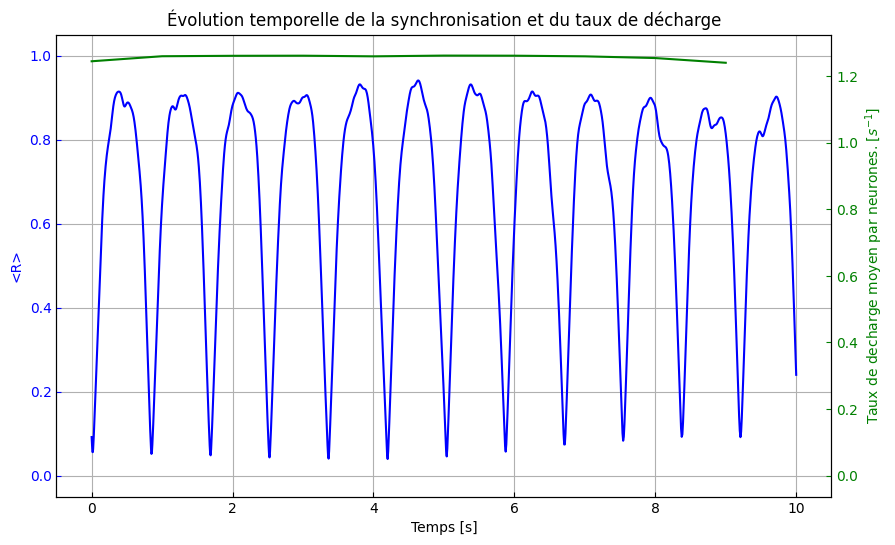

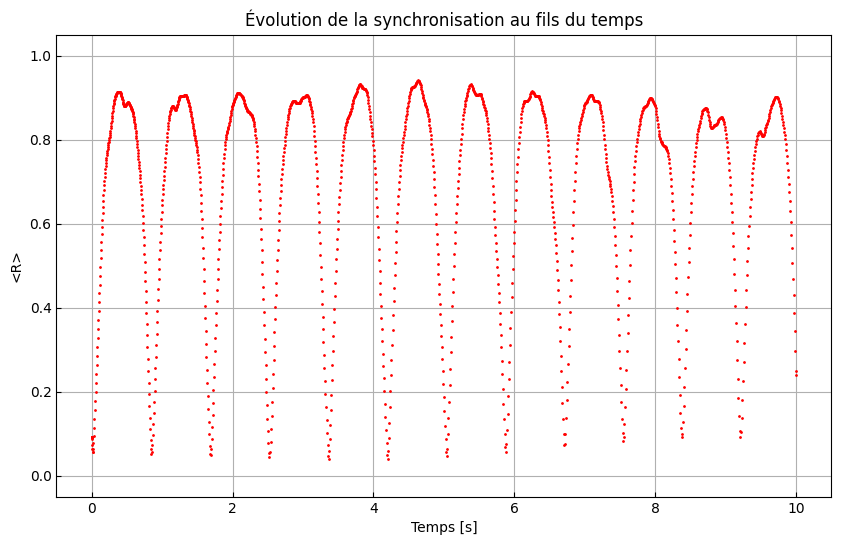

In [26]:
# Dynamique N neurone theta.
N = 100
euler = 0
scipy = 1
mean = 1


# kappas = [0, 1, 3, 5, 8, 11, 15]
kappas = [10]

# n_list = [1, 5, 10, 15, 30]
# n_list = [1, 3, 5, 8, 12]
n_list = [1]

# beta_mean = [-1, -0.5, -0.2, 0, 0.2, 0.5, 1]
# beta_mean = [-1]

# beta_sigma = [0, 0.02, 0.05, 0.1, 0.3, 0.5]
# beta_sigma = [0]

# theta_sigma = [0.001]
# theta_sigma = [0, 0.002, 0.01, 0.05, 0.1, 0.5, 1]

params2 = n_list

# kappas=beta_sigma

f_map = np.zeros((len(kappas), len(params2)))
# f_map_norm = np.zeros((len(kappas), len(n_list)))
R_map = np.zeros((len(kappas), len(params2), 2, mean))
for m in range(mean):
    # theta_0 = np.random.normal(0, 0, (N, 1))
    # theta_0 = np.random.standard_normal((N, 1))
    theta_0 = np.random.random((N, 1))*2*np.pi

    A = np.ones((N, N))#-np.identity(N)
    # A = np.random.normal(0.3, 0.05, (N, N))
    for j, kappa in enumerate(kappas):
        beta_0 = np.random.normal(1, 0.01, (N, 1))
        # rng = np.random.default_rng()  # use Generator API
        # beta_0 = true_samples(rng.standard_cauchy((N, 1)), -0.5, bDelta)
        for i, n in enumerate(params2):
            # theta_0 = np.random.normal(0, tsigma, (N, 1))
            # theta_0 = np.random.random((N, 1))*2*np.pi

            # n = 10
            # kappa = 6

            # beta_0 = -0.5
            # rng = np.random.default_rng()  # use Generator API
            # beta_0 = true_samples(rng.standard_cauchy((N, 1)), -0.5, bdelta)

            # beta_0 = np.random.normal(bmean, bsigma, (N, 1))
            

            a_n = 2**n*(facto(n))**2/facto(2*n)
            step_approx = 0.01/(2*(0.00001+np.mean(beta_0) + a_n*kappa*2**n))
            
            time_start = 0
            time_step = np.abs(step_approx)
            time_stop = 10
            time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


            if euler:
                theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, betaNneurones, A, n, beta_0, kappa)
            
            elif scipy:
                sol  = solve_ivp(theta_model_scipy_solver, [time_start, time_stop], theta_0.T[0], first_step=1e-10, max_step=0.1, atol = 0, rtol = 1e-10, args = (betaNneurones, A, n, beta_0, kappa))
                time_list, theta = sol.t, sol.y
            
            synchro = indice_syncronisation(theta)
            R, std_modif = half_mean(synchro, time_list, True)
            print(R, std_modif)
            R_map[j, i, :, m] = np.array([R, std_modif])

            raster_plot_scipy, fire_list = raster_and_frate_builder(time_list, theta, time_stop)
            f_map[j, i] += np.mean(fire_list[int(len(fire_list)/2):])/mean
            # f_map_norm[j, i] += half_mean(fire_list_norm)/mean
mean_std = np.std(R_map[:, :, 0, :], axis = 2)
R_map = np.mean(R_map, axis = 3)
R_map[:, :, 1] += mean_std/np.sqrt(mean)

if len(R_map) == 1 and mean == 1:
    if euler:
        fig_sync(time_list, theta)
        # fig_spike_rep(time_list, theta, theta_0)
        spike_rep_euler = spike_rep(theta, 30)/2**30
        raster_plot_array = []
        for neuron in spike_rep_euler:
            raster_plot_array += [time_list[find_peaks(neuron, 0.5)[0]]]
        fig_raster(raster_plot_array, time_stop)
        fig_heatmap(theta)

    # Scipy version
    if scipy:
        raster_plot_scipy, fire_list = raster_and_frate_builder(time_list, theta, time_stop)
        fig_sync_frate(time_list, theta, fire_list, neighbors=15)
        fig_sync(time_list, theta)
        # fig_frate(fire_list, 15)
        # fig_spike_rep(time_list, theta, theta_0)
        # fig_raster(raster_plot_scipy, time_stop)
        # fig_heatmap(theta)

else:
    fig_mean_sync_all(params2, R_map, kappas, labeltxt=r'$\kappa$', axis = 0, 
                    xlabel=r"n [-]", 
                    title=fr"Synchronisation moyenne pour différents $\kappa$ selon n.")#r'$\kappa$'
    
    fig_mean_sync_all(kappas, R_map, params2, labeltxt=r'n', 
                    xlabel=r'$\kappa$ [-]', 
                    title=fr"Synchronisation moyenne pour différents n selon $\kappa$.")
    
    fig_mean_frate(f_map, kappas, params2, xname=r'$\kappa [-]$', yname = r'n [-]')
    # fig_mean_frate(f_map_norm, kappas, n_list, title='Taux de décharge finale moyen normalisé.')

    fig_mean_sync_heat_map(R_map[:, :, 0], kappas, params2,xname=r'$\kappa$ [-]',  yname = r'n [-]')
    
    fig_3D(kappas, params2, R_map)


In [ ]:
# Definition des fonctions pour la réduction DART

# c_n = {1:{0:1, 1:-1}, 2:{0:3/2, 1:-2, 2:0.5}, 3:{0:5/2, 1:-3.75, 2:1.5, 3: -1/4}, 
#        4:{0:35/8, 1:-7, 2:3.5, 3:-1, 4:1/8}, 5:{0:63/8, 1:-105/8, 2:7.5, 3:-45/16, 4:15/24, 5:-15/240}}
# c_n = c_n_dict_bulder(51)

# def a_n_dict_check(s: int, n: int):
#     if s in c_n.keys():
#         a_n = c_n[s][n]
#     else:
#         print('STOP S is too big!')
#         a_n = numerical_An(s, n)
#     return a_n

def numerical_An(s: int, n: int):
    """Compute A_n for given s using numerical integration."""
    integrand = lambda theta: (1 - np.cos(theta))**s * np.cos(n * theta)
    result, _ = quad(integrand, 0, 2 * np.pi)
    if n==0:
        result /= 2
    return round(result / np.pi, 12) 

def a_n_close_form(s: int, n: int):
    a_n = 0
    for r in range(int(np.floor((s-n)/2))+1):
        a_n += comb(s, n+2*r)*(-0.5)**(n+2*r)*(comb(n+2*r, n+r)+comb(n+2*r, r))
    if n==0: a_n*=0.5
    return a_n

def c_n_dict_bulder(s: int):
    c_n={}
    for i in range(1, s+1):
        c_n[i]={}
        for j in range(i+1):
            c_n[i][j]=a_n_close_form(i, j)
    return c_n

def cos_expansion(Z: complex, s: int, c_n: dict):
    rep = 0
    a_n = 0
    max=s+1
    if max>101:
        max=101
    for n in range(max):
        a_n = c_n[s][n]
        rep+=a_n*(Z**n+np.conj(Z)**n)/2
    return rep

def Z_reduced_dynamic_manager(t, Z: np.ndarray, n: int, sigma: float, kappa: np.ndarray, Omega: np.ndarray,
                       W_curl: np.ndarray, K_curl: np.ndarray, A_curl: np.ndarray, s: int, N: int, a_s: float, c_eta: dict):
    Zdot = np.empty(np.shape(Z), dtype=complex)
    for mu in range(n):
        Zdot[mu]=Z_reduced_dynamic(t, Z, mu, sigma, kappa, Omega, W_curl, K_curl, A_curl, s, N, a_s, c_eta)[0]
    return Zdot

def Z_reduced_dynamic(t, Z: np.ndarray, mu: int, sigma: float, kappa: np.ndarray, Omega: np.ndarray,
                       W_curl: np.ndarray, K_curl: np.ndarray, A_curl: np.ndarray, s: int, N: int, a_s: float, c_eta: dict):
    sumeta = 0
    sumOm = W_curl[mu]@Z
    sumkap = K_curl[mu]@Z
    sumA = A_curl[mu]@Z
    sumAconj = A_curl[mu]@np.conj(Z)
    for eta in range(s+1):
        a_eta = c_eta[s][eta]
        sumeta += a_eta*(sumA**eta+sumAconj**eta)/(2*kappa[mu]**eta)
    return -0.5j*(Z[mu]-1)**2+0.5j*Omega[mu]*(sumOm/Omega[mu]+1)**2+0.5j*kappa[mu]*sigma*a_s*(sumkap/kappa[mu]+1)**2*(sumeta[0])/N

def Z_reduced_dynamic_homogeneOG(t, Z: complex, omega_mean: float, sigma: float, s: int, a_s: float):
    return -0.5j*(Z-1)**2+0.5j*(Z+1)**2*(omega_mean+sigma*a_s*(1-0.5*(Z+np.conj(Z)))**s)


def Z_reduced_dynamic_homogene(t, Z: complex, omega_mean: float, sigma: float, s: int, a_s: float, c_n: dict):
    h = a_s*cos_expansion(Z, s, c_n)
    return -0.5j*(Z-1)**2+0.5j*(Z+1)**2*(omega_mean+sigma*h)

def R_reduced_dynamic_homogene(R: float, Phi: float, omega_mean: float, sigma: float, s: int, a_s: float, c_n: dict):
    h = a_s*cos_expansion(R*np.exp(1j*Phi), s, c_n)
    return 0.5*(1-R**2)*np.sin(Phi)*(omega_mean-1+sigma*h)

def Phi_reduced_dynamic_homogene(R: float, Phi: float, omega_mean: float, sigma: float, s: int, a_s: float, c_n: dict):
    h = a_s*cos_expansion(R*np.exp(1j*Phi), s, c_n)
    return 1-(1+R**2)*np.cos(Phi)/(2*R)+(1+(1+R**2)*np.cos(Phi)/(2*R))*(omega_mean+sigma*h)

def R_Phi_reduced_dynamic_homogene(t, RPhi: np.ndarray, omega_mean: float, sigma: float, s: int, a_s: float, c_n: dict):
    R, Phi = RPhi
    Rdot = R_reduced_dynamic_homogene(R, Phi, omega_mean, sigma, s, a_s, c_n)
    Phidot = Phi_reduced_dynamic_homogene(R, Phi, omega_mean, sigma, s, a_s, c_n)
    return np.array([Rdot, Phidot])


def Moore_penrose(M: np.ndarray):
    return np.conj(M.T)@np.linalg.inv((M@(np.conj(M.T))))

def reduced_dynamic_params_init(M: np.ndarray, beta_0: np.ndarray, A: np.ndarray, z_0: np.ndarray, N: int):
    W = np.diag(beta_0.T[0])
    K = np.diag(np.sum(A, axis=1))
    # K = np.diag(np.sum(np.abs(A), axis=1))

    W_curl = M@W@Moore_penrose(M)
    K_curl = M@K@Moore_penrose(M)
    A_curl = M@A@Moore_penrose(M)
    Z_0 = M@z_0

    kappa, Omega = K_curl[0], W_curl[0]

    if not (M==np.ones((1, N))/N).all():
        kappa = M@K@np.ones((N, 1))
        Omega = M@W@np.ones((N, 1))
    return Z_0.T[0], kappa, Omega, K_curl, W_curl, A_curl, W, K

def fig_sync_reduced(time_list:np.ndarray, R:np.ndarray, xlabel:str="Temps [s]", 
             ylabel:str="<R> [-]", title:str="Évolution temporel de la synchronisation du modèle réduit"):
    plt.figure(figsize=(10, 6))
    plt.plot(time_list, R)#, 'ro', ms=1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.ylim(-0.05, 1.05)
    plt.show()

def fig_mean_sync_and_reduced(xdata:list, R_map:np.ndarray, reduced_map:np.ndarray, params:np.ndarray, labeltxt:str = r'$s$', axis:int = 1, stretchlim:bool = True,
                  xlabel:str=r"$\sigma$ [-]", ylabel:str="<R> [-]", 
                  title:str=r"Synchronisation totale d'un graph pour différents $\sigma$"):
    plt.figure(figsize=(7, 4))
    for i, param in enumerate(params):
        if axis:
            R_list = R_map[:, i, :]
            reduced_list = reduced_map[:, i, :]
        else:
            R_list = R_map[i]
            reduced_list = reduced_map[i]
        plt.plot(xdata, reduced_list[:, 0], 'o--', lw=1, ms=1, markeredgecolor='black', alpha=0.9, c='black')
        plt.fill_between(xdata, reduced_list[:, 0]+reduced_list[:, 1], reduced_list[:, 0]-reduced_list[:, 1], alpha=0.5, color='grey')
        plt.plot(xdata, R_list[:, 0], 'o-', lw=1, ms=2, markeredgecolor='red', label=labeltxt+f'={param}', alpha=0.7, c=f'C{i}')
        plt.fill_between(xdata, R_list[:, 0]+R_list[:, 1], R_list[:, 0]-R_list[:, 1], alpha=0.3, color=f'C{i}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim(-0.05, 1.05)
    if not stretchlim:
        plt.ylim(np.min(R_list[:, 0]-R_list[:, 1])-0.01, np.max(R_list[:, 0]+R_list[:, 1])+0.01)
    plt.grid(True)
    plt.show()

def V_A_builder(value, vector, n=2):
    V_A = np.empty((n, len(vector[:, 0])))
    valuemodified = value+0
    for i in range(n):
        v_max = np.max(np.abs(valuemodified))
        if v_max == 0:
            raise ValueError('La valeur propre maximal est trivial')
        v_idx = np.where(np.abs(valuemodified)==v_max)[0][0]
        valuemodified[v_idx] = 0
        V_A[i, :] = vector[:, v_idx]*np.sign(np.mean(vector[:, v_idx]))
    return V_A

def m_builder(M):
    m = np.count_nonzero(M, axis=1)/np.count_nonzero(M)
    if np.count_nonzero(M) > int(len(M[0])*len(M)):
        print('countM=', np.count_nonzero(M))
        print(m)
        raise ValueError('Too many non zero value in M')
    return m

def m_builder_weighted2(mat):
    m = np.sum(mat, axis=1)*np.count_nonzero(mat, axis=1)/np.count_nonzero(mat)
    return m/np.sum(m)

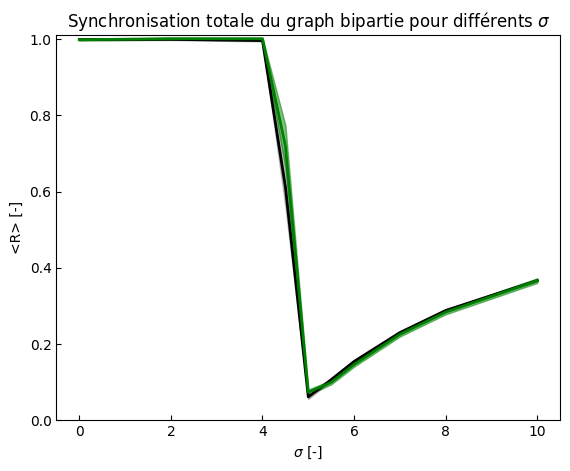

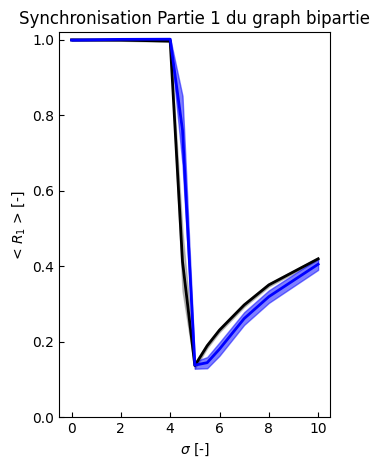

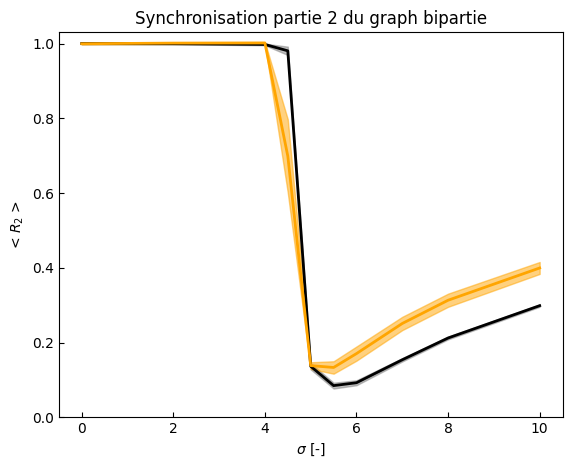

In [ ]:
# test reproduction résultat Threefold way


graph = False
# sigmas = [10]
# sigmas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sigmas = [0, 2, 4, 4.5, 5, 5.5, 6, 7, 8, 10]
# sigmas = sigmas[::2]
mean = 20

size = 250
c_eta_dict = c_n_dict_bulder(31)

R_map = np.empty((len(sigmas), 6, mean))
reduced_map = np.zeros((len(sigmas), 6, mean))
RR = np.empty((len(sigmas), 2, mean))
for m in range(mean):
    # theta_0 = np.random.standard_normal((size, 1))
    theta_0 = np.random.random((size, 1))*2*np.pi

    # Graph bibarti
    # G = nx.bipartite.random_graph(int(size*3/5), int(size*2/5), 0.2, directed=True)
    # A = np.array(nx.adjacency_matrix(G).toarray())

    # Graph SBM
    G = nx.stochastic_block_model([150, 100], [[0.7, 0.2], [0.2, 0.5]])
    A = np.array(nx.adjacency_matrix(G).toarray()).T
    
    beta_0 = np.concatenate((np.random.normal(-1.1, 0.0001, (int(size*3/5), 1)), np.random.normal(-0.9, 0.0001, (int(size*2/5), 1))), axis=0)
    value, vector = nplin.eig(A)

    # plt.imshow(A)
    # plt.show()


    # norm1 = np.sum(vector[:, 0][:150])
    # norm2 = np.sum(vector[:, 1][150:])
    # M2 = np.array([np.pad(vector[:, 0][:150], (0, 100), 'constant', constant_values=0)/norm1, np.pad(vector[:, 1][150:], (150, 0), 'constant', constant_values=0)/norm2])
    
    # value, vector = nplin.eig(A)
    # V_A = np.real(vector).T[:2:-1] #np.array([vector[:, 0], vector[:, 1]], dtype = float)
    V_A = np.abs(V_A_builder(np.real(value), np.real(vector)))
    M, snmf_frobenius_error, onmf_frobenius_error, onmf_ortho_error = get_reduction_matrix(V_A)

    # plt.figure(figsize=(18, 12))
    # plt.imshow(V_A)
    # plt.colorbar()
    # plt.show()
    
    # if M[0, 0] < M[0, -1]:
    #     M[:] = M[::-1]
    #     print('wut')
    # print(M[0, :5])
    # print(M[0, -5:])
    # print(M[1, :5])
    # print(M[1, -5:])
    # print(np.max(M), np.max(M2), np.max(np.abs(M-M2)))
    
    # M = np.array([np.pad(np.ones(150), (0, 100), 'constant', constant_values=0)/150, np.pad(np.ones(100), (150, 0), 'constant', constant_values=0)/100])
    # M = np.ones((1, size))/size
    for i, sigma in enumerate(sigmas):
        s = 1
        time_start = 0
        time_stop = 50

        sol  = solve_ivp(theta_model_scipy_solver, [time_start, time_stop], theta_0.T[0], max_step=0.1, atol = 0, rtol = 1e-10, args = (betaNneurones, A, s, beta_0, sigma))
        theta, time_list = sol.y, sol.t

        synchro = indice_syncronisation(theta)
        synchro35 = indice_syncronisation(theta[: int(size*3/5)])
        synchro25 = indice_syncronisation(theta[- int(size*2/5)+1:])
        R, std = half_mean(synchro, time_list, True)
        R1, std1 = half_mean(synchro35, time_list, True)
        R2, std2 = half_mean(synchro25, time_list, True)
        R_map[i, :, m] = np.array([R, R1, R2, std, std1, std2])



        z_0 = np.exp(1j*theta_0)
        Z_0, kappa, Omega, K_curl, W_curl, A_curl, W, K = reduced_dynamic_params_init(M, beta_0, A, z_0, size)
        a_s = 2**s*(facto(s))**2/facto(2*s)

        # n=1
        # sol  = solve_ivp(Z_reduced_dynamic_manager, [time_start, time_stop], Z_0, max_step=0.1, atol = 0, rtol = 1e-10, args = (n, sigma, kappa, Omega, W_curl, K_curl, A_curl, s, size, a_s))
        # time_list_reduced, Z= sol.t, sol.y[0]
        # R_reduced, Phi = np.abs(Z), np.angle(Z)
        # Rmean, std_modif_reduced = half_mean(R_reduced, time_list_reduced, True)
        # RR[i, :, m] = np.array([Rmean, std_modif_reduced])
        
        n=2
        sol  = solve_ivp(Z_reduced_dynamic_manager, [time_start, time_stop], Z_0, max_step=0.1, atol = 0, rtol = 1e-10, args = (n, sigma, kappa, Omega, W_curl, K_curl, A_curl, s, size, a_s, c_eta_dict))
        time_list_reduced, Z1, Z2 = sol.t, sol.y[0], sol.y[1]
        Z=Z1*3/5+Z2*2/5
        R1_reduced, Phi = np.abs(Z1), np.angle(Z1)
        R2_reduced, Phi = np.abs(Z2), np.angle(Z2)
        R_reduced, Phi = np.abs(Z), np.angle(Z)

        Rmean, std_modif_reduced = half_mean(R_reduced, time_list_reduced, True)
        R1mean, std1_modif_reduced = half_mean(R1_reduced, time_list_reduced, True)
        R2mean, std2_modif_reduced = half_mean(R2_reduced, time_list_reduced, True)
        reduced_map[i, :, m] = np.array([Rmean, R1mean, R2mean, std_modif_reduced, std1_modif_reduced, std2_modif_reduced])
mean_std = np.std(R_map[:, :3, :], axis = 2)
R_map = np.mean(R_map, axis = 2)
R_map[:, 3:] += mean_std/np.sqrt(mean)

mean_std_reduced = np.std(reduced_map[:, :3, :], axis = 2)
reduced_map = np.mean(reduced_map, axis = 2)
reduced_map[:, 3:] += mean_std_reduced/np.sqrt(mean)

# mean_std_RR = np.std(RR[:, 0, :], axis = 1)
# RR = np.mean(RR, axis = 2)
# RR[:, 1] += mean_std_RR/np.sqrt(mean)

if not graph:
    plt.figure(figsize=(6.5, 5))
    plt.plot(sigmas, R_map[:, 0], lw=2, c='black')
    plt.fill_between(sigmas, R_map[:, 0]+R_map[:, 3], R_map[:, 0]-R_map[:, 3], alpha=0.5, color='grey')
    plt.plot(sigmas, reduced_map[:, 0], lw=2, c='green')#, label=f'<R>={R}'
    plt.fill_between(sigmas, reduced_map[:, 0]+reduced_map[:, 3], reduced_map[:, 0]-reduced_map[:, 3], alpha=0.5, color='green')
    # plt.plot(sigmas, RR[:, 0], lw=2, c='red')#, label=f'<R>={R}'
    # plt.fill_between(sigmas, RR[:, 0]+RR[:, 1], RR[:, 0]-RR[:, 1], alpha=0.5, color='red')
    plt.xlabel(r"$\sigma$ [-]")
    plt.ylabel(r"<R> [-]")
    plt.title(r"Synchronisation totale du graph bipartie pour différents $\sigma$")
    plt.tick_params(direction = 'in')
    plt.ylim(0, 1.01)
    plt.show()

    plt.figure(figsize=(3.5, 5))
    plt.plot(sigmas, R_map[:, 1], lw=2, c='black')
    plt.fill_between(sigmas, R_map[:, 1]+R_map[:, 4], R_map[:, 1]-R_map[:, 4], alpha=0.5, color='grey')
    plt.plot(sigmas, reduced_map[:, 1], lw=2, c='blue')#, label=f'<R>={R}'
    plt.fill_between(sigmas, reduced_map[:, 1]+reduced_map[:, 4], reduced_map[:, 1]-reduced_map[:, 4], alpha=0.5, color='blue')
    plt.xlabel(r"$\sigma$ [-]")
    plt.ylabel(r'< $R_1$ > [-]')
    plt.title(r"Synchronisation Partie 1 du graph bipartie")
    plt.tick_params(direction = 'in')
    plt.ylim(0, 1.02)
    plt.show()

    plt.figure(figsize=(6.5, 5))
    plt.plot(sigmas, R_map[:, 2], lw=2, c='black')
    plt.fill_between(sigmas, R_map[:, 2]+R_map[:, 5], R_map[:, 2]-R_map[:, 5], alpha=0.5, color='grey')
    plt.plot(sigmas, reduced_map[:, 2], lw=2, c='orange')#, label=f'<R>={R}'
    plt.fill_between(sigmas, reduced_map[:, 2]+reduced_map[:, 5], reduced_map[:, 2]-reduced_map[:, 5], alpha=0.5, color='orange')
    plt.xlabel(r"$\sigma$ [-]")
    plt.ylabel(r"< $R_2$ >")
    plt.title(r"Synchronisation partie 2 du graph bipartie")
    plt.tick_params(direction = 'in')
    plt.ylim(0, 1.03)
    plt.show()

if graph:
    plt.figure(figsize=(10, 6))
    plt.plot(time_list, synchro, label=f'<R>={R}')#, 'ro', ms=1
    plt.plot(time_list_reduced, R_reduced, label=f'<R>={Rmean}')#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"<R> [-]")
    plt.title(r"Évolution de la synchronisation au fils du temps")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(time_list, synchro35, label=fr'< R$>_1$={R1}')#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"< R$>_1$ [-]")
    plt.title(r"Évolution de la synchronisation au fils du temps (groupe 1)")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(time_list, synchro25, label=fr'< R$>_2$={R2}')#, 'ro', ms=1
    plt.plot(time_list_reduced, R2_reduced, label=fr'< R$>_2$={R2mean}')#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"< R$>_2$ [-]")
    plt.title(r"Évolution de la synchronisation au fils du temps (groupe 2)")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.legend()
    plt.show()


    raster_plot_array = []

    plt.figure(figsize=(10, 10))
    for i in range(len(theta_0)):
        spike_rep_list = spike_rep(theta[i], 30)/2**30
        plt.plot(time_list, i+spike_rep_list, label = fr'$\theta_0={theta_0[i]}$')
        raster_plot_array += [time_list[find_peaks(spike_rep_list, 0.5)[0]]]
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"valeur de (1-cos$(\theta ))^{30}$ normalisé [-]")
    plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    # plt.legend()
    plt.show()

    plt.figure(figsize=(15, 4))
    output = spike_rep(theta, 30)/2**30
    V_spike_mat = np.repeat(output, 10, axis=0)
    plt.imshow(V_spike_mat)
    plt.colorbar()
    plt.xlabel(fr"Temps [{time_step}s]")
    plt.ylabel(r"Énumération des neurones. [-]")
    plt.title(r"Heat map d'émission de potentiel des neurones.")
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.eventplot(raster_plot_array[::-1])
    plt.xlabel(fr"Temps [s]")
    plt.ylabel(r"Énumération des neurones. [-]")
    plt.title(r"Raster plot des pics d'émission de potentiel des neurones.")
    plt.grid(True)
    # plt.margins(0)
    plt.xlim(0, time_stop)
    plt.ylim(0)
    plt.show()

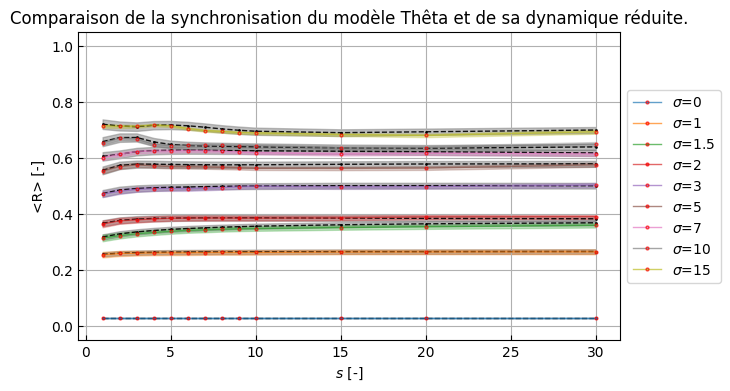

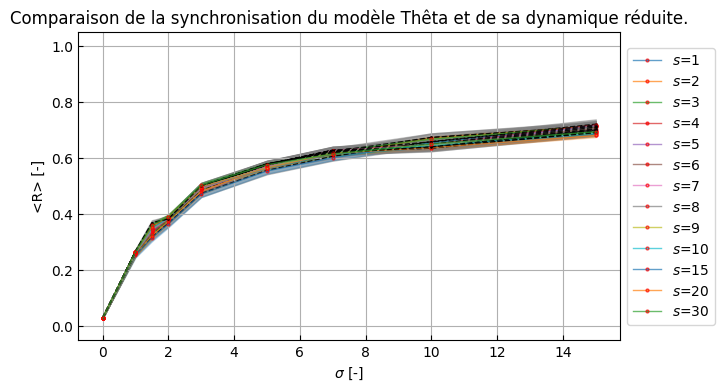

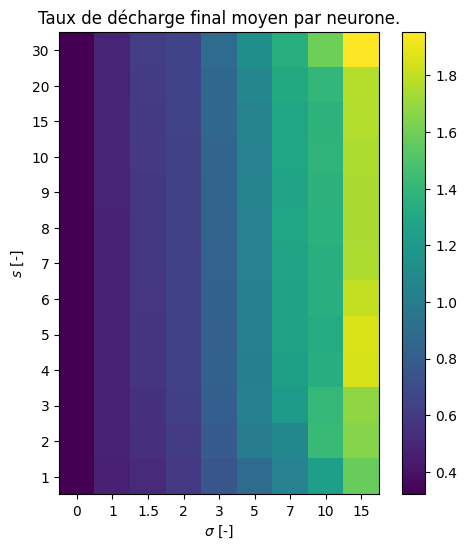

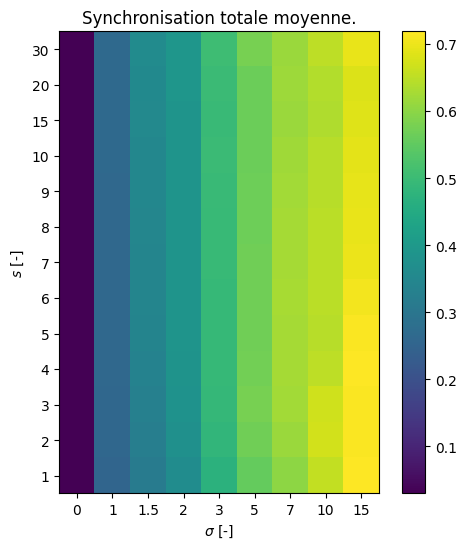

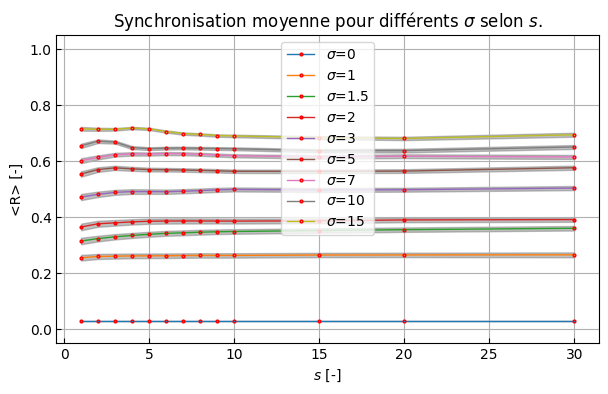

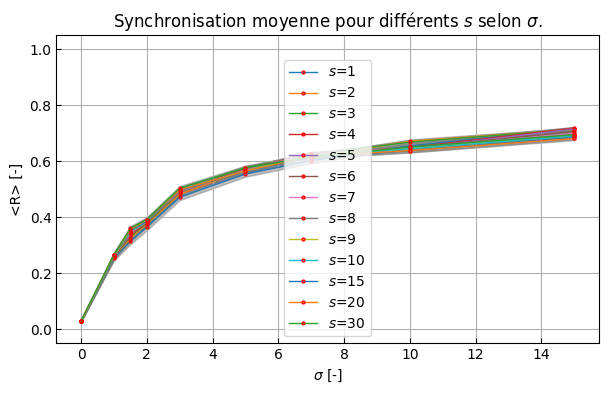

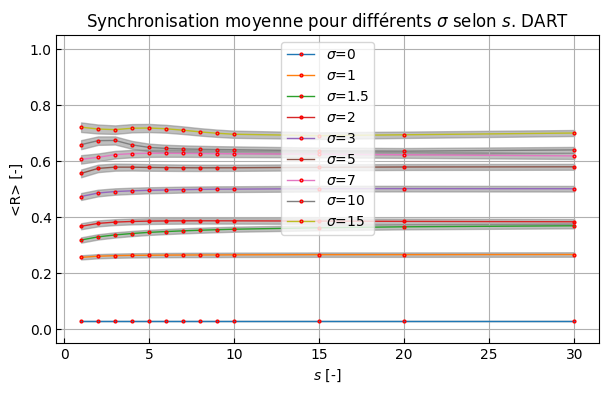

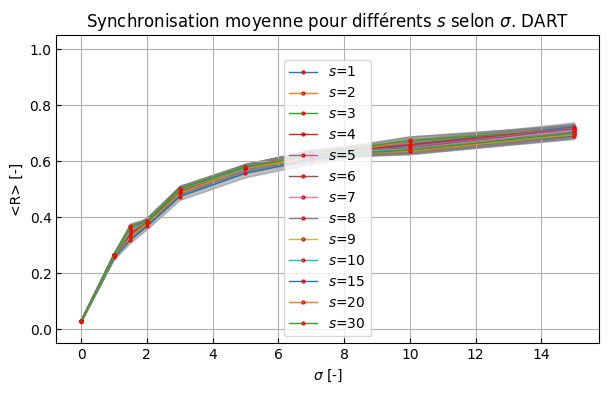

In [10]:
# Dynamique N neurone theta comparé avec DART
N = 100
mean = 1

sigmas = [0, 1, 1.5, 2, 3, 5, 7, 10, 15]
# sigmas = [2, 3, 5, 10]
# sigmas = [3]

s_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
# s_list = [1, 2, 3, 5, 7, 10, 15, 20, 30]
# s_list = [3]

# omega_list = [-0.5, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.5, 0.8, 1]
# omega_list = [ -0.7, -0.5, 0, 0.5, 1]

# sig_omega_list = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.65, 0.8, 1]
# sig_omega_list = [0.01, 0.3, 0.6, 1]
# sig_omega_list = [0.1]

params2 = s_list

# sigmas=omega_list

c_eta_dict = c_n_dict_bulder(51)

f_map = np.zeros((len(sigmas), len(params2)))
R_map = np.zeros((len(sigmas), len(params2), 2, mean))
reduced_map = np.zeros((len(sigmas), len(params2), 2, mean))
for m in range(mean):
    theta_0 = np.random.random((N, 1))*np.pi*2
    # theta_0 = np.random.standard_normal((N, 1))
    A = np.ones((N, N))
    beta_0 = np.random.normal(1, 0, (N, 1))
    for i, s in enumerate(params2):
        for j, sigma in enumerate(sigmas):
            
            # s = 2
            # sigma = 2
            a_s = 2**s*(facto(s))**2/facto(2*s)

            time_start = 0
            time_stop = 10

            sol  = solve_ivp(theta_model_scipy_solver, [time_start, time_stop], theta_0.T[0], first_step=1e-10, max_step=0.1, atol = 0, rtol = 1e-10, args = (betaNneurones, A, s, beta_0, sigma))
            time_list, theta = sol.t, sol.y
            
            synchro = indice_syncronisation(theta)
            R, std_modif = half_mean(synchro, time_list, True)
            R_map[j, i, :, m] = np.array([R, std_modif])

            raster_plot_scipy, fire_list = raster_and_frate_builder(time_list, theta, time_stop)
            f_map[j, i] += np.mean(fire_list[int(len(fire_list)/2):])/mean



            z_0 = np.exp(1j*theta_0)
            omega_mean = np.mean(beta_0)
            M = np.ones((1, N))/N
            Z_0 = M@z_0

            # sol  = solve_ivp(Z_reduced_dynamic_homogeneOG, [time_start, time_stop], Z_0[0], max_step=0.1, atol = 0, rtol = 1e-10, args = (omega_mean, sigma, s, a_s))
            # time_list, Z = sol.t, sol.y[0]
            # R, Phi = np.abs(Z), np.angle(Z)
            # Rm, std_modif = half_mean(R, time_list, True)
            # R_map[j, i, :, m] = np.array([Rm, std_modif])

            sol  = solve_ivp(Z_reduced_dynamic_homogene, [time_start, time_stop], Z_0[0], max_step=0.1, atol = 0, rtol = 1e-10, args = (omega_mean, sigma, s, a_s, c_eta_dict))
            time_list_reduced, Z = sol.t, sol.y[0]
            R_reduced, Phi = np.abs(Z), np.angle(Z)
            Rmean, std_modif_reduced = half_mean(R_reduced, time_list_reduced, True)
            reduced_map[j, i, :, m] = np.array([Rmean, std_modif_reduced])

mean_std = np.std(R_map[:, :, 0, :], axis = 2)
R_map = np.mean(R_map, axis = 3)
R_map[:, :, 1] += mean_std/np.sqrt(mean)

mean_std_reduced = np.std(reduced_map[:, :, 0, :], axis = 2)
reduced_map = np.mean(reduced_map, axis = 3)
reduced_map[:, :, 1] += mean_std_reduced/np.sqrt(mean)


if len(R_map) == 1 and mean == 1:
    raster_plot_scipy, fire_list = raster_and_frate_builder(time_list, theta, time_stop)
    print(R, std_modif)
    fig_sync_frate(time_list, theta, fire_list, neighbors=15)
    # fig_sync(time_list, theta)
    # fig_frate(fire_list, 15)
    # fig_spike_rep(time_list, theta, theta_0)
    # fig_raster(raster_plot_scipy, time_stop)
    # fig_heatmap(theta)
    print(Rmean, std_modif_reduced)
    fig_sync_reduced(time_list_reduced, R_reduced, )

else:
    fig_mean_sync_and_reduced(params2, R_map, reduced_map, sigmas, labeltxt=r'$\sigma$', axis=0, xlabel=r"$s$ [-]",
                              title=fr"Comparaison de la synchronisation du modèle Thêta et de sa dynamique réduite.")
    fig_mean_sync_and_reduced(sigmas, R_map, reduced_map, params2, labeltxt=r'$s$', xlabel=r"$\sigma$ [-]",
                              title=fr"Comparaison de la synchronisation du modèle Thêta et de sa dynamique réduite.")

    fig_mean_frate(f_map, sigmas, params2, xname=r'$\sigma$ [-]', yname = r'$s$ [-]', colo_horizon=False)

    fig_mean_sync_heat_map(R_map[:, :, 0], sigmas, params2,xname=r'$\sigma$ [-]',  yname = r'$s$ [-]', colo_horizon=False)



    fig_mean_sync_all(params2, R_map, sigmas, labeltxt=r'$\sigma$', axis = 0, 
                    xlabel=r"$s$ [-]", 
                    title=fr"Synchronisation moyenne pour différents $\sigma$ selon $s$.")#r'$\kappa$'
    
    fig_mean_sync_all(sigmas, R_map, params2, labeltxt=r'$s$', 
                    xlabel=r'$\sigma$ [-]', 
                    title=fr"Synchronisation moyenne pour différents $s$ selon $\sigma$.")
    

    fig_mean_sync_all(params2, reduced_map, sigmas, labeltxt=r'$\sigma$', axis = 0, 
                    xlabel=r"$s$ [-]", 
                    title=fr"Synchronisation moyenne pour différents $\sigma$ selon $s$. DART")#r'$\kappa$'
    
    fig_mean_sync_all(sigmas, reduced_map, params2, labeltxt=r'$s$', 
                    xlabel=r'$\sigma$ [-]', 
                    title=fr"Synchronisation moyenne pour différents $s$ selon $\sigma$. DART")


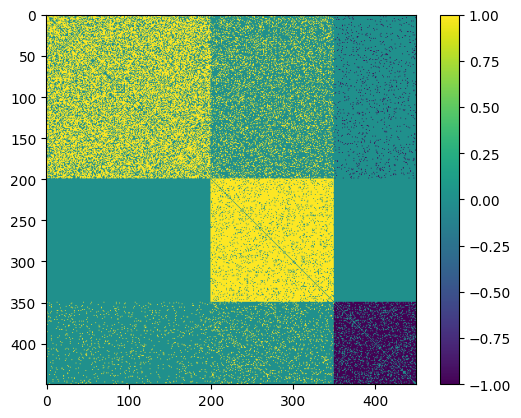


snmf_ferr =  1.2242005130332404e-07
max iter onmf

onmf_ferr = 1.0780866440627973e-08  
onmf_oerr = 0.0010110514875722358
[0.44444444 0.33333333 0.22222222] [1. 0. 0.] [0. 1. 0.] [0. 0. 1.]


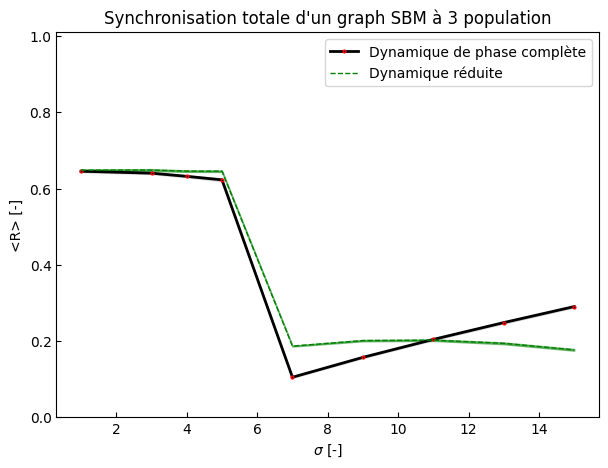

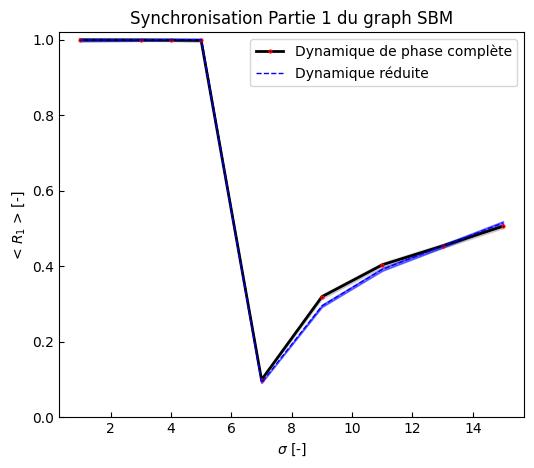

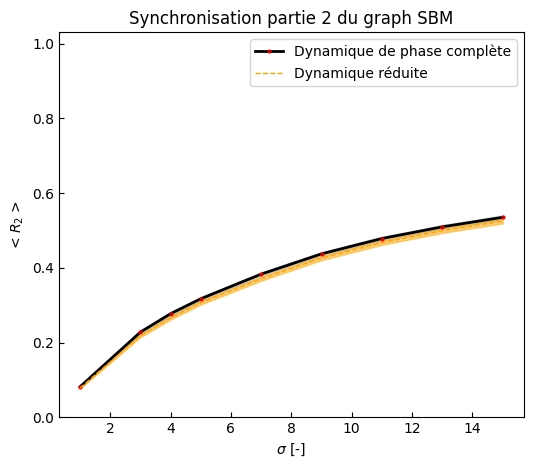

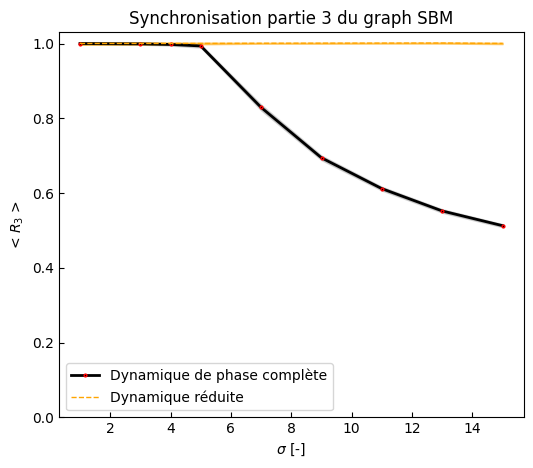

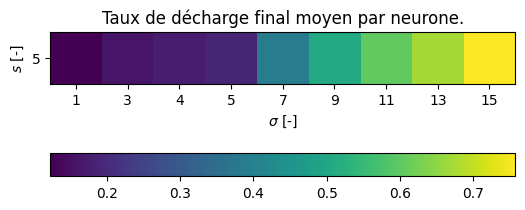

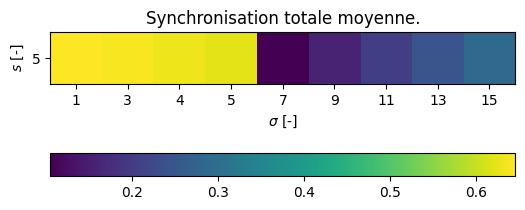

In [41]:
# Dynamique N neurones avec A par bloc

DART = True
sigmas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
sigmas = [1, 3, 4, 5, 7, 9, 11, 13, 15]
# sigmas = sigmas[::2]
# sigmas = [3]
mean = 1

size1 = 200
size2 = 150
size3 = 100
size = size1+size2+size3
c_eta_dict = c_n_dict_bulder(31)

# R_map = np.empty((len(sigmas), 6, mean))
# reduced_map = np.zeros((len(sigmas), 6, mean))
R_map = np.empty((len(sigmas), 8, mean))
reduced_map = np.zeros((len(sigmas), 8, mean))
f_map = np.zeros((len(sigmas), 1))
for itm in range(mean):
    theta_0 = np.random.random((size, 1))*2*np.pi
    # theta_0 = np.random.normal(1, 0.5, (size, 1))
    # print(np.mean(theta_0), np.mean(theta_0[: size1]), np.mean(theta_0[-size2:]))
    # theta_0 = np.random.standard_normal((size, 1))

    # Graph SBM
    p1=0.6
    p2=0.9
    p3=0.8
    px12=0.2
    px13=0.05
    px23=0.1
    # G = nx.stochastic_block_model([size1, size2], [[p1, px12], [px12, p2]])
    G = nx.stochastic_block_model([size1, size2, size3], [[p1, px12, px13], [px12, p2, px23], [px13, px23, p3]])
    # G = nx.stochastic_block_model([size1, size2], [[1, 0], [0, 1]])
    A = np.array(nx.adjacency_matrix(G).toarray()).T
    A[:, -size3:] *= -1
    # A[size1:, :size1] = 0
    A[size1:size1+size2, :size1] = 0
    A[size1:size1+size2, -size3:] = 0
    # beta_0 = np.concatenate((np.random.normal(-2, 0.0001, (size1, 1)), np.random.normal(1, 0.0001, (size2, 1))), axis=0)
    beta_0 = np.concatenate((np.random.normal(-1.5, 0.0001, (size1, 1)), np.random.normal(1, 0.0001, (size2, 1)), np.random.normal(-0.5, 0.0001, (size3, 1))), axis=0)
    plt.imshow(A)
    plt.colorbar()
    plt.show()
    if DART:
        value, vector = nplin.eig(A)
        n=3
        # W = np.diag(beta_0.T[0])
        # valueW, vectorW = nplin.eig(W)
        # V_W = V_A_builder(np.real(valueW), np.real(vectorW), n)
        # print(valueW)
        # plt.imshow(vectorW)
        # plt.show()
        # plt.figure(figsize=(18, 12))
        # plt.imshow(np.pad(V_W, ((2, 2), (0, 0)), 'constant', constant_values=0))
        # plt.colorbar()
        # plt.show()
        V_A = V_A_builder(np.real(value), np.real(vector), n)
        # plt.figure(figsize=(18, 12))
        # plt.imshow(np.pad(V_A, ((2, 2), (0, 0)), 'constant', constant_values=0))
        # plt.colorbar()
        # plt.show()
        V_none = np.zeros(np.shape(V_A))
        V_T1, V_T2, V_T3 = V_A, V_none, V_none
        # M = np.array([np.pad(np.ones(150), (0, 100), 'constant', constant_values=0)/150, np.pad(np.ones(100), (150, 0), 'constant', constant_values=0)/100])
        M, snmf_frobenius_error, onmf_frobenius_error, onmf_ortho_error = get_reduction_matrix(V_T1, V_T2, V_T3, number_initializations=10000)
        # M = np.eye(55)
        # M = msave+0
        M[M<1e-5/size] = 0
        M = M/np.sum(M, axis=1, keepdims=True)
        
        clearM=M+0
        clearM[clearM<1/size]=0
        clearM = clearM/np.sum(clearM, axis=1, keepdims=True)
        m1 = m_builder_weighted2(clearM[:, :size1])
        m2 = m_builder_weighted2(clearM[:, size1:size2+size1])
        idx1 = np.where(m1-m2==np.max(m1-m2))[0][0]
        idx2 = np.where(m2-m1==np.max(m2-m1))[0][0]
        if idx1 == 1 and idx2 == 0:
            M[:2] = M[1::-1]
        elif idx1 == 0 and idx2 == 1:
            pass
        else:
            if idx2 == 0:
                M[[1, 0]] = M[[0, 1]]
                M[[0, idx1]] = M[[idx1, 0]]
            else:
                M[[0, idx1]] = M[[idx1, 0]]
                M[[1, idx2]] = M[[idx2, 1]]

        # plt.figure(figsize=(18, 12))
        # plt.imshow(np.pad(M, ((2, 2), (0, 0)), 'constant', constant_values=0))
        # plt.colorbar()
        # plt.show()
        clearM=M+0
        clearM[clearM<1/size]=0
        clearM = clearM/np.sum(clearM, axis=1, keepdims=True)
        m = m_builder_weighted2(clearM)
        m1 = m_builder_weighted2(clearM[:, :size1])
        m2 = m_builder_weighted2(clearM[:, size1:size2+size1])
        m3 = m_builder_weighted2(clearM[:, size1+size2:])
        print(m, m1, m2, m3)
        if np.count_nonzero(clearM[0, -size2:])>np.count_nonzero(clearM[1, -size2:]):
            print(np.count_nonzero(M, axis=1), np.count_nonzero(M[:, :size1], axis=1), np.count_nonzero(M[:, -size2:], axis=1))
            plt.figure(figsize=(18, 12))
            plt.imshow(np.pad(M, ((2, 2), (0, 0)), 'constant', constant_values=0))
            plt.colorbar()
            plt.show()
            raise ValueError('wrong config pour M')
        z_0 = np.exp(1j*theta_0)
        Z_0, kappa, Omega, K_curl, W_curl, A_curl, W, K = reduced_dynamic_params_init(M, beta_0, A, z_0, size)
        # print('kappa=', kappa.T, '\n', 'Omega=', Omega.T, '\n', 'K_curl=', K_curl, '\n', 'W_curl=', W_curl, '\n', 'A_curl=', A_curl)
    for i, sigma in enumerate(sigmas):
        s = 5
        time_start = 0
        time_stop = 30

        sol  = solve_ivp(theta_model_scipy_solver, [time_start, time_stop], theta_0.T[0], max_step=0.1, atol = 0, rtol = 1e-10, args = (betaNneurones, A, s, beta_0, sigma))
        theta, time_list = sol.y, sol.t

        synchro = indice_syncronisation(theta)
        synchro35 = indice_syncronisation(theta[: size1])
        synchro25 = indice_syncronisation(theta[size1:size2+size1])
        synchro3 = indice_syncronisation(theta[size2+size1:])
        R, std = half_mean(synchro, time_list, True)
        R1, std1 = half_mean(synchro35, time_list, True)
        R2, std2 = half_mean(synchro25, time_list, True)
        R3, std3 = half_mean(synchro3, time_list, True)
        R_map[i, :, itm] = np.array([R, R1, R2, R3, std, std1, std2, std3])

        raster_plot_scipy, fire_list = raster_and_frate_builder(time_list, theta, time_stop)
        f_map[i, 0] += np.mean(fire_list[int(len(fire_list)/2):])/mean

        if DART:
            a_s = 2**s*(facto(s))**2/facto(2*s)

            sol  = solve_ivp(Z_reduced_dynamic_manager, [time_start, time_stop], Z_0, max_step=0.1, atol = 0, rtol = 1e-10, args = (n, sigma, kappa, Omega, W_curl, K_curl, A_curl, s, size, a_s, c_eta_dict))
            time_list_reduced, Zall = sol.t, sol.y
            # Z1, Z2 = Zall[0], Zall[1]
            Z1 = m1@Zall
            Z2 = m2@Zall
            Z3 = m3@Zall
            Z = m@Zall
            # Z = 0.6*Zall[0]+0.4*Zall[1]
            R1_reduced, Phi = np.abs(Z1), np.angle(Z1)
            R2_reduced, Phi = np.abs(Z2), np.angle(Z2)
            R3_reduced, Phi = np.abs(Z3), np.angle(Z3)
            R_reduced, Phi = np.abs(Z), np.angle(Z)

            Rmean, std_modif_reduced = half_mean(R_reduced, time_list_reduced, True)
            R1mean, std1_modif_reduced = half_mean(R1_reduced, time_list_reduced, True)
            R2mean, std2_modif_reduced = half_mean(R2_reduced, time_list_reduced, True)
            R3mean, std3_modif_reduced = half_mean(R3_reduced, time_list_reduced, True)
            reduced_map[i, :, itm] = np.array([Rmean, R1mean, R2mean, R3mean, std_modif_reduced, std1_modif_reduced, std2_modif_reduced, std3_modif_reduced])
mean_std = np.std(R_map[:, :4, :], axis = 2)
R_map = np.mean(R_map, axis = 2)
R_map[:, 4:] += mean_std/np.sqrt(mean)

if DART:
    mean_std_reduced = np.std(reduced_map[:, :4, :], axis = 2)
    reduced_map = np.mean(reduced_map, axis = 2)
    reduced_map[:, 4:] += mean_std_reduced/np.sqrt(mean)

if len(R_map) == 1 and mean == 1:
    raster_plot_scipy, fire_list = raster_and_frate_builder(time_list, theta, time_stop)
    print(R, std_modif)
    fig_sync_frate(time_list, theta, fire_list, neighbors=15)
    fig_sync(time_list, theta[: size1])
    fig_sync(time_list, theta[- size2:])
    # fig_sync(time_list, theta)
    # fig_frate(fire_list, 15)
    fig_spike_rep(time_list, theta, theta_0)
    fig_raster(raster_plot_scipy, time_stop)
    # fig_heatmap(theta)
    print(Rmean, std_modif_reduced)
    fig_sync_reduced(time_list_reduced, R_reduced)
    fig_sync_reduced(time_list_reduced, R1_reduced)
    fig_sync_reduced(time_list_reduced, R2_reduced)

else:
    plt.figure(figsize=(7, 5))
    plt.plot(sigmas, R_map[:, 0], 'o-', lw=2, ms=2, markeredgecolor='red', c='black', label='Dynamique de phase complète')
    plt.fill_between(sigmas, R_map[:, 0]+R_map[:, 4], R_map[:, 0]-R_map[:, 4], alpha=0.3, color='grey')
    if DART:
        plt.plot(sigmas, reduced_map[:, 0], '--', lw=1, c='green', label='Dynamique réduite')#, label=f'<R>={R}'
        plt.fill_between(sigmas, reduced_map[:, 0]+reduced_map[:, 4], reduced_map[:, 0]-reduced_map[:, 4], alpha=0.5, color='green')
    plt.xlabel(r"$\sigma$ [-]")
    plt.ylabel(r"<R> [-]")
    plt.title(fr"Synchronisation totale d'un graph SBM à 3 population")#avec P11={p1}, P22={p2}, P12=P21={px}
    plt.tick_params(direction = 'in')
    plt.ylim(0, 1.01)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(sigmas, R_map[:, 1], 'o-', lw=2, ms=2, markeredgecolor='red', c='black', label='Dynamique de phase complète')
    plt.fill_between(sigmas, R_map[:, 1]+R_map[:, 5], R_map[:, 1]-R_map[:, 5], alpha=0.3, color='grey')
    if DART:
        plt.plot(sigmas, reduced_map[:, 1], '--', lw=1, c='blue', label='Dynamique réduite')#, label=f'<R>={R}'
        plt.fill_between(sigmas, reduced_map[:, 1]+reduced_map[:, 5], reduced_map[:, 1]-reduced_map[:, 5], alpha=0.5, color='blue')
    plt.xlabel(r"$\sigma$ [-]")
    plt.ylabel(r'< $R_1$ > [-]')
    plt.title(r"Synchronisation Partie 1 du graph SBM")
    plt.tick_params(direction = 'in')
    plt.ylim(0, 1.02)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(sigmas, R_map[:, 2], 'o-', lw=2, ms=2, markeredgecolor='red', c='black', label='Dynamique de phase complète')
    plt.fill_between(sigmas, R_map[:, 2]+R_map[:, 6], R_map[:, 2]-R_map[:, 6], alpha=0.3, color='grey')
    if DART:
        plt.plot(sigmas, reduced_map[:, 2], '--', lw=1, c='orange', label='Dynamique réduite')#, label=f'<R>={R}'
        plt.fill_between(sigmas, reduced_map[:, 2]+reduced_map[:, 6], reduced_map[:, 2]-reduced_map[:, 6], alpha=0.5, color='orange')
    plt.xlabel(r"$\sigma$ [-]")
    plt.ylabel(r"< $R_2$ >")
    plt.title(r"Synchronisation partie 2 du graph SBM")
    plt.tick_params(direction = 'in')
    plt.ylim(0, 1.03)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(sigmas, R_map[:, 3], 'o-', lw=2, ms=2, markeredgecolor='red', c='black', label='Dynamique de phase complète')
    plt.fill_between(sigmas, R_map[:, 3]+R_map[:, 7], R_map[:, 3]-R_map[:, 7], alpha=0.3, color='grey')
    if DART:
        plt.plot(sigmas, reduced_map[:, 3], '--', lw=1, c='orange', label='Dynamique réduite')#, label=f'<R>={R}'
        plt.fill_between(sigmas, reduced_map[:, 3]+reduced_map[:, 7], reduced_map[:, 3]-reduced_map[:, 7], alpha=0.5, color='orange')
    plt.xlabel(r"$\sigma$ [-]")
    plt.ylabel(r"< $R_3$ >")
    plt.title(r"Synchronisation partie 3 du graph SBM")
    plt.tick_params(direction = 'in')
    plt.ylim(0, 1.03)
    plt.legend()
    plt.show()

    fig_mean_frate(f_map, sigmas, np.array([s]), xname=r'$\sigma$ [-]', yname = r'$s$ [-]', colo_horizon=True)

    fig_mean_sync_heat_map(R_map[:, :1], sigmas, np.array([s]),xname=r'$\sigma$ [-]',  yname = r'$s$ [-]', colo_horizon=True)


In [644]:
msave = M+0

[0.66666667 0.33333333] [1. 0.] [0. 1.]
1.0 1.0 1.0
[200 100]
[0.66666667 0.33333333]
[0.66666667 0.33333333]


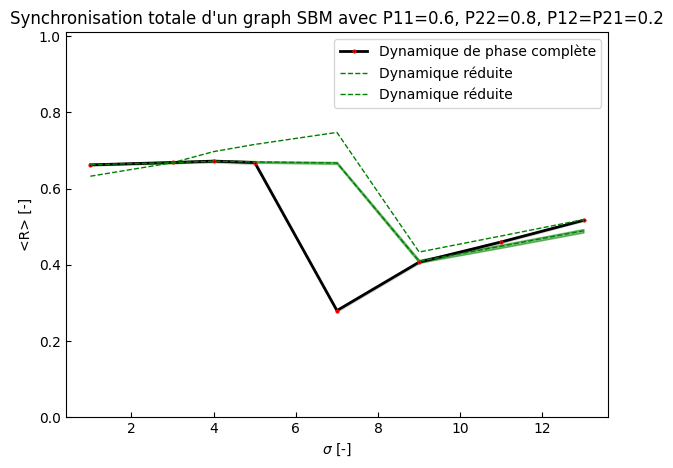

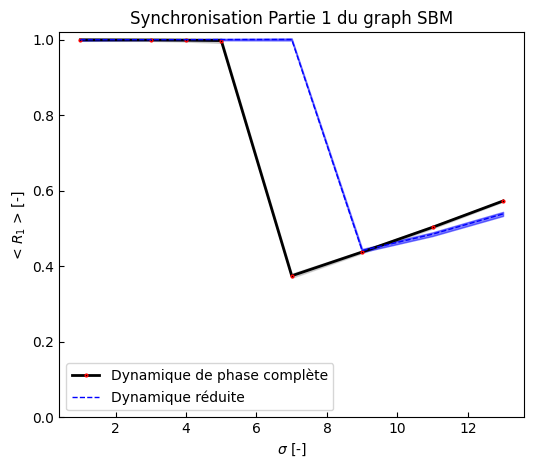

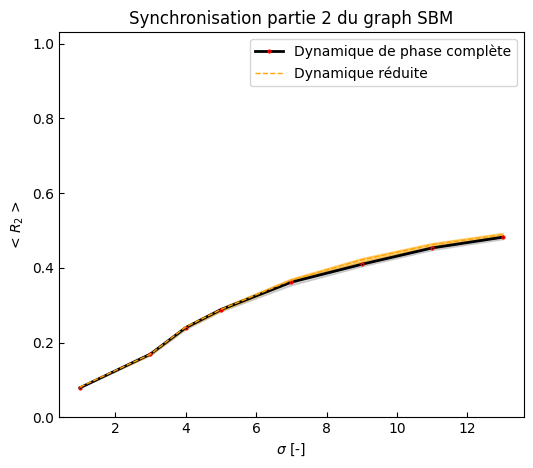

IndexError: index 8 is out of bounds for axis 1 with size 6

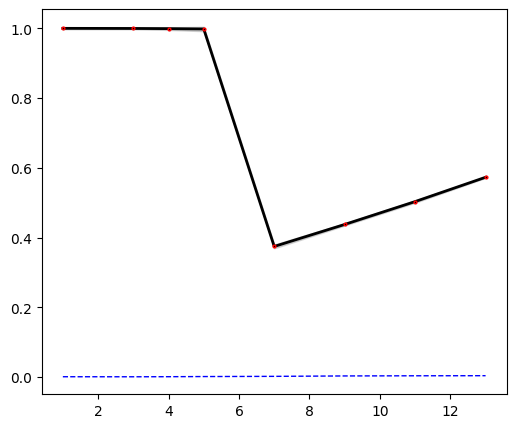

In [861]:
print(m, m1, m2)
print(np.sum(m), np.sum(m1), np.sum(m2))
print(np.count_nonzero(M, axis=1))
print(m_builder_weighted2(M))
print(m_builder(clearM))
plt.figure(figsize=(7, 5))
plt.plot(sigmas, R_map[:, 0], 'o-', lw=2, ms=2, markeredgecolor='red', c='black', label='Dynamique de phase complète')
# plt.plot(sigmas, R_map[:, 2], 'o-', lw=2, ms=2, markeredgecolor='red', label='Dynamique de phase complète2')
# plt.plot(sigmas, R_map[:, 1], 'o-', lw=2, ms=2, markeredgecolor='red', label='Dynamique de phase complète1')
plt.fill_between(sigmas, R_map[:, 0]+R_map[:, 3], R_map[:, 0]-R_map[:, 3], alpha=0.3, color='grey')
if DART:
    plt.plot(sigmas, reduced_map[:, 0], '--', lw=1, c='green', label='Dynamique réduite')#, label=f'<R>={R}'
    plt.plot(sigmas, reduced_map[:, 1]*3/5+reduced_map[:, 2]*2/5, '--', lw=1, c='green', label='Dynamique réduite')#, label=f'<R>={R}'
    plt.fill_between(sigmas, reduced_map[:, 0]+reduced_map[:, 3], reduced_map[:, 0]-reduced_map[:, 3], alpha=0.5, color='green')
plt.xlabel(r"$\sigma$ [-]")
plt.ylabel(r"<R> [-]")
plt.title(fr"Synchronisation totale d'un graph SBM avec P11={p1}, P22={p2}, P12=P21={px}")
plt.tick_params(direction = 'in')
plt.ylim(0, 1.01)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(sigmas, R_map[:, 1], 'o-', lw=2, ms=2, markeredgecolor='red', c='black', label='Dynamique de phase complète')
plt.fill_between(sigmas, R_map[:, 1]+R_map[:, 4], R_map[:, 1]-R_map[:, 4], alpha=0.3, color='grey')
if DART:
    plt.plot(sigmas, reduced_map[:, 1], '--', lw=1, c='blue', label='Dynamique réduite')#, label=f'<R>={R}'
    plt.fill_between(sigmas, reduced_map[:, 1]+reduced_map[:, 4], reduced_map[:, 1]-reduced_map[:, 4], alpha=0.5, color='blue')
plt.xlabel(r"$\sigma$ [-]")
plt.ylabel(r'< $R_1$ > [-]')
plt.title(r"Synchronisation Partie 1 du graph SBM")
plt.tick_params(direction = 'in')
plt.ylim(0, 1.02)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(sigmas, R_map[:, 2], 'o-', lw=2, ms=2, markeredgecolor='red', c='black', label='Dynamique de phase complète')
plt.fill_between(sigmas, R_map[:, 2]+R_map[:, 5], R_map[:, 2]-R_map[:, 5], alpha=0.3, color='grey')
if DART:
    plt.plot(sigmas, reduced_map[:, 2], '--', lw=1, c='orange', label='Dynamique réduite')#, label=f'<R>={R}'
    plt.fill_between(sigmas, reduced_map[:, 2]+reduced_map[:, 5], reduced_map[:, 2]-reduced_map[:, 5], alpha=0.5, color='orange')
plt.xlabel(r"$\sigma$ [-]")
plt.ylabel(r"< $R_2$ >")
plt.title(r"Synchronisation partie 2 du graph SBM")
plt.tick_params(direction = 'in')
plt.ylim(0, 1.03)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(sigmas, R_map[:, 1], 'o-', lw=2, ms=2, markeredgecolor='red', c='black', label='Dynamique de phase complète')
plt.fill_between(sigmas, R_map[:, 1]+R_map[:, 4], R_map[:, 1]-R_map[:, 4], alpha=0.3, color='grey')
if DART:
    plt.plot(sigmas, reduced_map[:, 3], '--', lw=1, c='blue', label='Dynamique réduite')#, label=f'<R>={R}'
    plt.fill_between(sigmas, reduced_map[:, 3]+reduced_map[:, 8], reduced_map[:, 3]-reduced_map[:, 8], alpha=0.5, color='blue')
plt.xlabel(r"$\sigma$ [-]")
plt.ylabel(r'< $R_1$ > [-]')
plt.title(r"Synchronisation Partie 1 du graph SBM")
plt.tick_params(direction = 'in')
plt.ylim(0, 1.02)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(sigmas, R_map[:, 2], 'o-', lw=2, ms=2, markeredgecolor='red', c='black', label='Dynamique de phase complète')
plt.fill_between(sigmas, R_map[:, 2]+R_map[:, 5], R_map[:, 2]-R_map[:, 5], alpha=0.3, color='grey')
if DART:
    plt.plot(sigmas, reduced_map[:, 4], '--', lw=1, c='orange', label='Dynamique réduite')#, label=f'<R>={R}'
    plt.fill_between(sigmas, reduced_map[:, 4]+reduced_map[:, 9], reduced_map[:, 4]-reduced_map[:, 9], alpha=0.5, color='orange')
plt.xlabel(r"$\sigma$ [-]")
plt.ylabel(r"< $R_2$ >")
plt.title(r"Synchronisation partie 2 du graph SBM")
plt.tick_params(direction = 'in')
plt.ylim(0, 1.03)
plt.legend()
plt.show()

m            [0.41964286 0.29761905 0.2827381 ] [0.67336683 0.         0.32663317] [0.05147059 0.72794118 0.22058824]
m réduit     [0.39862543 0.34364261 0.25773196] [0.69461078 0.         0.30538922] [0.         0.80487805 0.19512195]
m pondéré plus    [0.39862543 0.34364261 0.25773196] [0.74482185 0.         0.25517815] [0.        0.9486277 0.0513723]
mcount       [141 100  95] [134   0  65] [  7 100  30] [ 127 -100   35]
336
mréduitcount [116 100  75] [116   0  51] [  0 100  24] [ 116 -100   27]
291


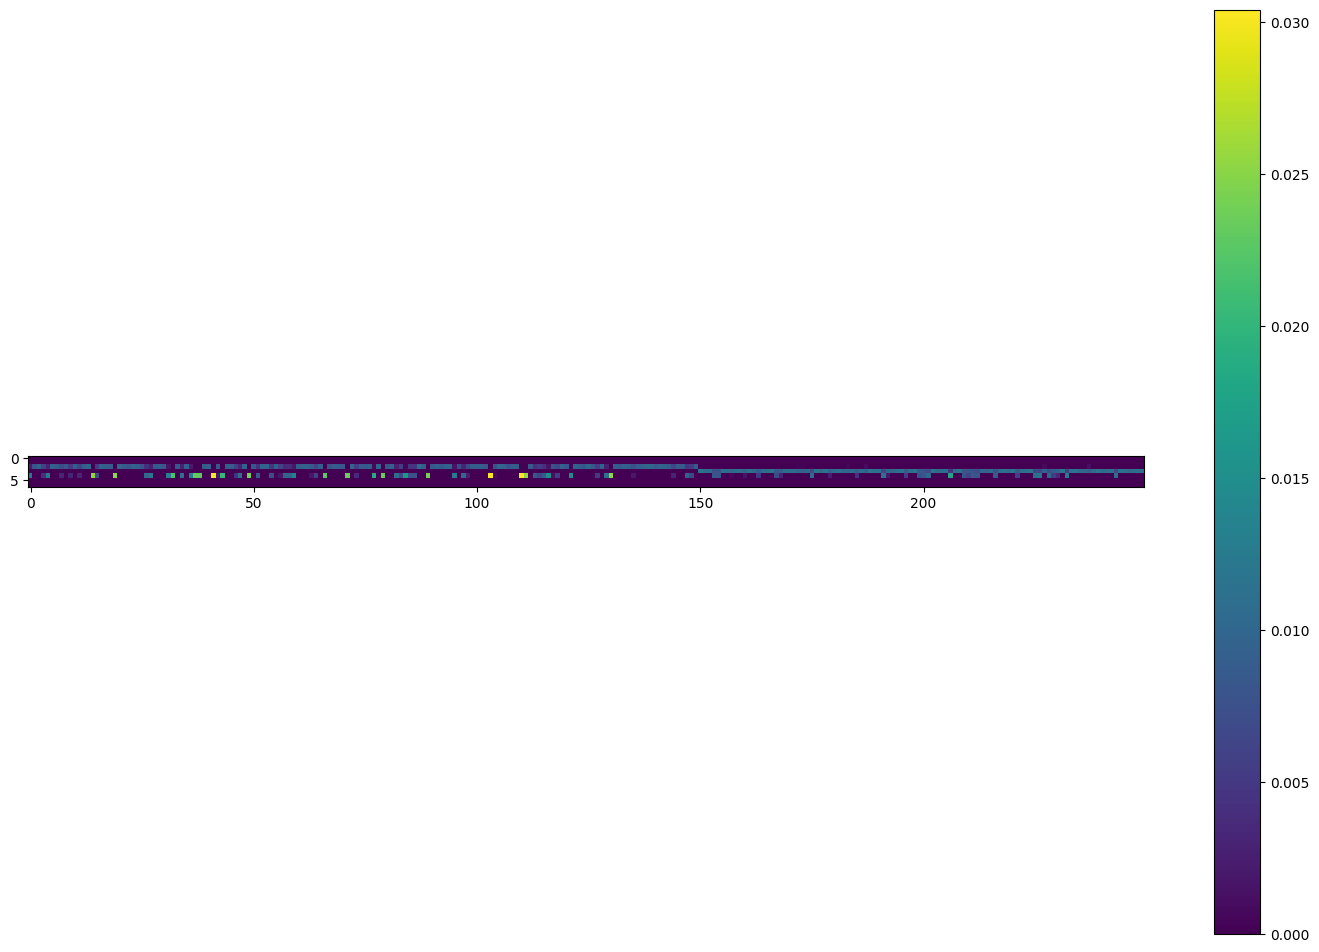

In [595]:
M = msave+0
M[M<1/size] = 0
M = M/np.sum(M, axis=1, keepdims=True)
print('m           ', m_builder(msave), m_builder(msave[:,:size1]), m_builder(msave[:, -size2+1:]))
print('m réduit    ', m_builder(M), m_builder(M[:,:size1]), m_builder(M[:, -size2+1:]))
# print('m pondéré   ', m_builder_weighted(msave), m_builder_weighted(msave[:,:size1]), m_builder_weighted(msave[:, -size2+1:]))
# print('m réduit pondéré   ', m_builder_weighted(M), m_builder_weighted(M[:,:size1]), m_builder_weighted(M[:, -size2+1:]))

# def m_builder_weighted2(mat):
#     m = np.sum(mat, axis=1)*np.count_nonzero(mat, axis=1)/np.count_nonzero(mat)
#     print(np.sum(mat, axis=1))
#     return m/np.sum(m)

# raaa = m_builder(M[:, -size2+1:])*m_builder_weighted(msave[:, -size2+1:])
# print(raaa/np.sum(raaa))

print('m pondéré plus   ', m_builder_weighted2(M), m_builder_weighted2(M[:,:size1]), m_builder_weighted2(M[:, -size2+1:]))



m = np.count_nonzero(msave, axis=1)
m1 = np.count_nonzero(msave[:,:size1], axis=1)
m2 = np.count_nonzero(msave[:,-size2:],  axis=1)
print('mcount      ', m, m1, m2, m1-m2)
print(np.sum(m))
m = np.count_nonzero(M, axis=1)
m1 = np.count_nonzero(M[:,:size1], axis=1)
m2 = np.count_nonzero(M[:,-size2:],  axis=1)
print('mréduitcount', m, m1, m2, m1-m2)
print(np.sum(m))
plt.figure(figsize=(18, 12))
plt.imshow(np.pad(msave[:, :], ((2, 2), (0, 0)), 'constant', constant_values=0))
plt.colorbar()
plt.show()



[-0.06653396-0.14595369j -0.03681537-0.04430819j]


C:\Users\bedba\AppData\Local\Temp\ipykernel_19140\1854337624.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Zdot[mu]=Z_reduced_dynamic(t, Z, mu, sigma, kappa, Omega, W_curl, K_curl, A_curl, s, N, a_s)


[[-0.06653396-0.14595369j -0.06527677-0.14352276j -0.0606949 -0.13419878j
  ... -0.71779653-0.11171474j -0.71274491-0.12470288j
  -0.70874274-0.13398065j]
 [-0.03681537-0.04430819j -0.03643469-0.04156141j -0.03521251-0.03112282j
  ... -0.71209289-0.06036948j -0.70922452-0.07280607j
  -0.70682273-0.08171324j]]
(np.float64(0.49823878019909545), np.float64(0.013200350275270323))


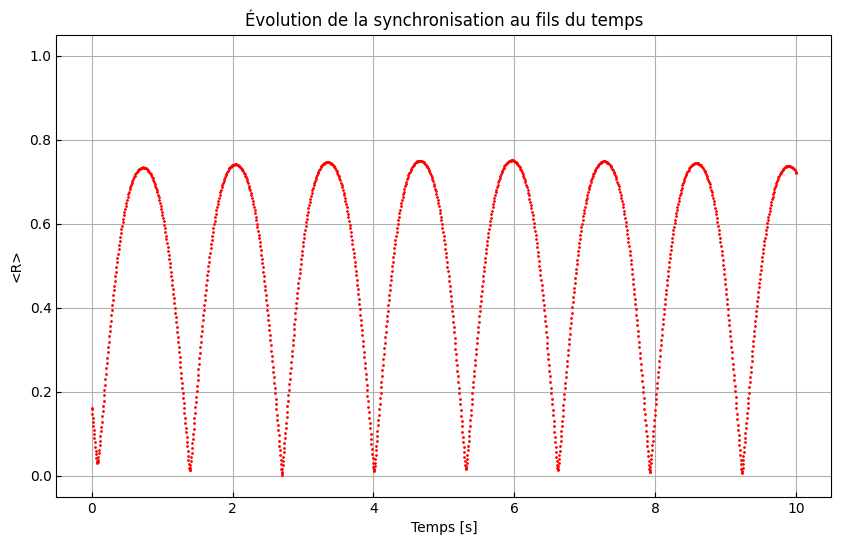

[ 0.16040339 -1.99850995]
val initiales R Phi:  [0.16040339 0.05760718] [-1.99850995 -2.2640927 ]
Vitesse init:  [-1.89097544+0.j  0.60825639+0.j]
val final R:  0.48149880861153227 0.023091934370014385


C:\Users\bedba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_ivp\base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


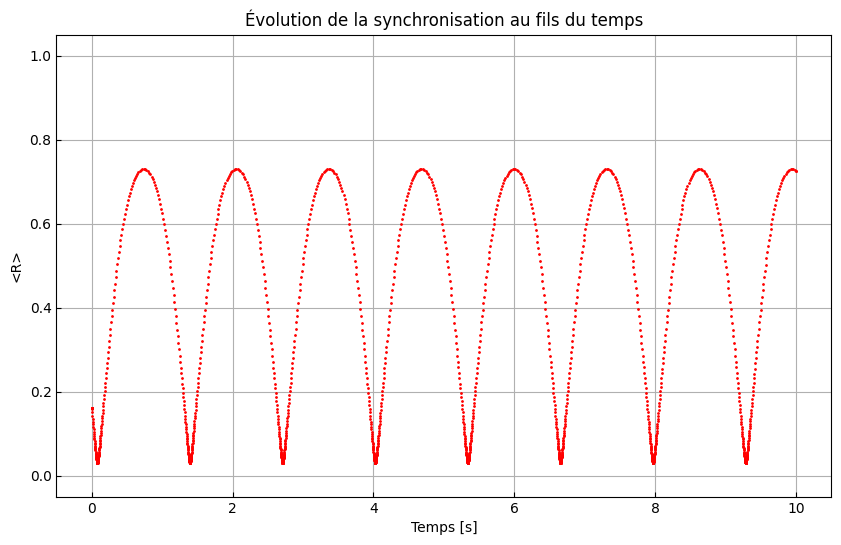

In [ ]:
# Dynamique N neurone theta.
N = 100

theta_0 = np.random.random((N, 1))*2*np.pi
z_0 = np.exp(1j*theta_0)

beta_0 = np.random.normal(1, 0, (N, 1))
omega_mean = np.mean(beta_0)

A = np.ones((N, N))
M = np.ones((1, N))/N
m = np.round(np.random.rand(1,N))
M2 = np.concatenate( (m/np.sum(m), (np.ones((1, N))-m)/(N-np.sum(m))), axis=0)

Z_0, kappa, Omega, K_curl, W_curl, A_curl, W, K = reduced_dynamic_params_init(M2, beta_0, A, z_0, N)
print(Z_0)

time_start = 0
time_stop = 10

sigma = 4
s = 1
a_s = 2**s*(facto(s))**2/facto(2*s)
c_eta_dict = c_n_dict_bulder(s)
n = 2
sol  = solve_ivp(Z_reduced_dynamic_manager, [time_start, time_stop], Z_0, max_step=0.1, atol = 0, rtol = 1e-10, args = (n, sigma, kappa, Omega, W_curl, K_curl, A_curl, s, N, a_s, c_eta_dict))
time_list, Z = sol.t, sol.y[0]
print(sol.y)
# sol  = solve_ivp(Z_reduced_dynamic_homogene, [time_start, time_stop], Z_0[0], max_step=0.1, atol = 0, rtol = 1e-10, args = (omega_mean, sigma, s, a_s))
# time_list, Z = sol.t, sol.y[0]
R, Phi = np.abs(Z), np.angle(Z)

print(half_mean(R, time_list, True))
plt.figure(figsize=(10, 6))
plt.plot(time_list, R, 'ro', ms=1)#, 'ro', ms=1
plt.xlabel("Temps [s]")
plt.ylabel("<R>")
plt.title("Évolution de la synchronisation au fils du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.ylim(-0.05, 1.05)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(time_list, Phi)#, 'ro', ms=1
# plt.plot(time_list, np.sin(Phi))#, 'ro', ms=1
# plt.xlabel("Temps [s]")
# plt.ylabel("<Phi>")
# plt.title("Évolution de la synchronisation au fils du temps")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# # plt.ylim(-0.05, 1.05)
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(np.diff(time_list))#, 'ro', ms=1
# plt.xlabel("Tdif [s]")
# plt.ylabel("pas de temps")
# plt.title("Évolution de la synchronisation au fils du temps")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# # plt.ylim(-0.05, 1.05)
# plt.show()


# raise ValueError('pause')



R_0 = np.abs(Z_0)
Phi_0 = np.angle(Z_0)
RPhi_0 = np.array([R_0, Phi_0]).T[0]
print(RPhi_0)

print('val initiales R Phi: ', R_0, Phi_0)
print('Vitesse init: ', R_Phi_reduced_dynamic_homogene(0, RPhi_0, omega_mean, sigma, s, a_s))

sol  = solve_ivp(R_Phi_reduced_dynamic_homogene, [time_start, time_stop], RPhi_0, first_step=1e-10, max_step=0.1, atol = 0, rtol = 1e-10, args = (omega_mean, sigma, s, a_s, c_eta_dict))
time_list, R, Phi = sol.t, sol.y[0], sol.y[1]

R_mean, std_modif = half_mean(R, time_list, True)
Phi_mean, Phi_std_modif = half_mean(Phi, time_list, True)

print('val final R: ', R_mean, std_modif)

plt.figure(figsize=(10, 6))
plt.plot(time_list, R, 'ro', ms=1)#, 'ro', ms=1
plt.xlabel("Temps [s]")
plt.ylabel("<R>")
plt.title("Évolution de la synchronisation au fils du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.ylim(-0.05, 1.05)
plt.show()


# RT, PhiT = R_Phi_reduced_dynamic_homogene(0, sol.y, omega_mean, sigma, s, a_s)


In [ ]:
raster_plot_scipy, fire_list = raster_and_frate_builder(time_list, theta, time_stop)
fig_sync_frate(time_list, theta, fire_list, neighbors=10)
# fig_sync(time_list, theta)
# fig_frate(fire_list, 10)
fig_spike_rep(time_list, theta, theta_0)
fig_raster(raster_plot_scipy, time_stop)
# fig_heatmap(theta)

In [ ]:
fig_mean_sync_all(n_list, R_map, kappas, labeltxt=r'$\kappa$', axis = 0, 
                xlabel=r"n [-]", 
                title=fr"Synchronisation moyenne pour différents $\kappa$ selon n.")

fig_mean_sync_all(kappas, R_map, n_list, 
                xlabel=r"$\kappa$ [-]", 
                title=fr"Synchronisation moyenne pour différents n selon $\kappa$.")

fig_mean_frate(f_map, kappas, n_list)
# fig_mean_frate(f_map_norm, kappas, n_list, title='Taux de décharge finale moyen normalisé.')

fig_3D(kappas, n_list, R_map)

Networkx
- gnm
- Erdos-Renyi ++
- Configuration model

poid sompolinski

In [ ]:
# Erdos-Renyi exemple by Networkx
n = 10  # 10 nodes
m = 20  # 20 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)

pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos, with_labels=True)
plt.show()

In [ ]:
# Configuration model exemple and try about multigraph plot (unsuccesful)
degree_list = [4, 7, 3, 6, 2, 3, 5, 2]
G = nx.configuration_model(degree_list)
graph_degree = int(sum(degree_list)/2)
print(G, graph_degree)

A = np.array(nx.adjacency_matrix(G).toarray())
print(np.sum(A+np.diag(np.diag(A)), axis=1))
print(list(G.edges))

plt.figure(figsize=(12, 6))
nx.draw_networkx(G, style=':', edge_color=tuple(np.linspace(0, 1, graph_degree)),  with_labels=True)
plt.show()

plt.imshow(A, cmap='plasma')
plt.colorbar()
plt.show()

In [ ]:
# Latex code for k_5 graph
G1 = nx.dense_gnm_random_graph(5, 10)
G = nx.complete_graph(5)
A = nx.adjacency_matrix(G)
print(np.array(A.toarray()))
nx.draw_shell(G, with_labels=True)
print(nx.to_latex(G, caption="Pentagrame"))

In [ ]:
G = nx.bipartite.random_graph(15, 10, 0.5)
A = np.array(nx.adjacency_matrix(G).toarray())
print(A)
nx.draw_bipartite(G)

snmf_frobenius_error_svd =  5.189695290418947e-06
snmf_frobenius_error_random =  5.132511717702187e-06
snmf_frobenius_error_random =  5.0580353128517245e-06
snmf_frobenius_error_random =  4.743855855596324e-06
snmf_frobenius_error_random =  4.46168286543953e-06
snmf_frobenius_error_random =  4.459070976632602e-06
snmf_frobenius_error_random =  4.302968570039744e-06
snmf_frobenius_error_random =  4.279666403501612e-06
snmf_frobenius_error_random =  4.26834351979245e-06

snmf_ferr =  4.26834351979245e-06


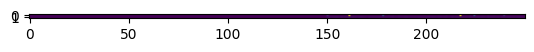

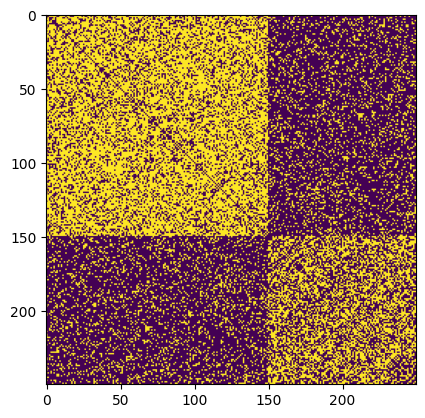

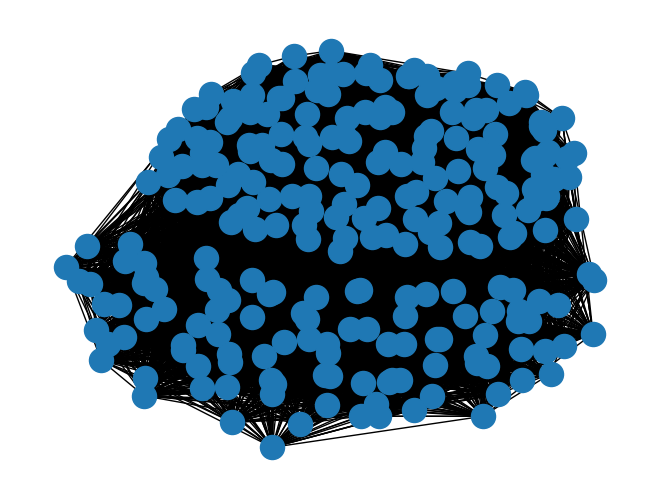

In [ ]:
G = nx.stochastic_block_model([150, 100], [[0.7, 0.2], [0.2, 0.5]])
A = np.array(nx.adjacency_matrix(G).toarray())

value, vector = nplin.eig(A)
V_A = np.array([vector[:, 0], vector[:, 1]])
V_none = np.zeros(np.shape(V_A))
V_T1, V_T2, V_T3 = V_A, V_none, V_none
M, snmf_frobenius_error, onmf_frobenius_error, onmf_ortho_error = \
    get_reduction_matrix(V_T1, V_T2, V_T3, other_procedure=True)

plt.imshow(M)
plt.show()
plt.imshow(A)
plt.show()
nx.draw(G)
plt.show()